# YouTube 조회수 예측 모델 분석

**감성적 피처 기반 YouTube 영상 조회수 예측**

---

## 📊 프로젝트 개요

이 노트북에서는 YouTube 영상의 감성적 피처를 활용하여 조회수를 예측하는 머신러닝 모델을 학습하고 분석합니다.

### 주요 피처 카테고리

1. **썸네일 피처**: 텍스트 비율, 색상 분포, 밝기 대비, 질감, 얼굴/객체 탐지
2. **오디오 피처**: 
   - **Audio Emotional** (감정 분류): `happy`, `sad`, `angry`, `fear`, `surprise`, `disgust`, `neutral`
   - **Audio Quantitative** (음악적 특성): BPM, 피치, 에너지, 스펙트럼 중심 등
3. **제목 피처**: 이모지, 특수문자, 해시태그, 문자 길이
4. **메타 피처**: 업로드 시간대, 구독자 수, 콘텐츠 타입

### 모델링 목표

- **Target Variable**: 로그 변환된 조회수 (`log_views`)
  - 조회수의 왜도를 정규화하고 이상치 영향 완화
- **평가 지표**: RMSE (Root Mean Squared Error)
- **Best Model**: XGBoost (Optuna 하이퍼파라미터 튜닝, RMSE 1.9170)
- **연구 목표**: 감성적 피처를 통한 조회수 예측 가능성 검증

---

## 📁 데이터 구조

```
final_data.csv
├── video_id              # 영상 ID
├── publish_date          # 업로드 날짜
├── subscriber_count      # 구독자 수
├── views                 # 조회수 (원본)
├── log_views             # 로그 변환된 조회수 (Target)
├── sensibility/daily     # 콘텐츠 타입
├── [썸네일 피처]         # text_ratio, colors, brightness, faces, objects 등
├── [오디오 감정 피처]    # happy, sad, angry, fear, surprise, disgust, neutral
├── [오디오 음악 피처]    # bpm, pitch_mean, energy_mean 등
├── [제목 피처]           # has_emoji, hashtag_count, char_length 등
└── [메타 피처]           # time_midnight, time_match_content 등
```

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import shap


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import VotingRegressor
import xgboost
import lightgbm
import xgboost as xgb
import lightgbm as lgb
import optuna

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import pickle

plt.rcParams['font.family'] = 'AppleGothic'  # 맥북에서 사용 가능한 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 기호 깨짐 방지

In [3]:
import sklearn
sklearn.__version__

'1.5.2'

In [4]:
xgboost.__version__

'2.1.4'

In [5]:
lightgbm.__version__

'4.6.0'

In [6]:
optuna.__version__

'4.3.0'

# 데이터 불러오기 및 확인

In [8]:
raw_data = pd.read_csv('../rawData/final_data.csv', encoding='utf-8')
raw_data

,video_id,publish_date,subscriber_count,views,sensibility,daily,hashtags,total_faces,faces_8_percent,frontal_faces_8_percent,...,genre_mentioned,hashtag_count,time_evening,time_midnight,time_morning,time_night,time_noon,time_match_content,text_char_combo,object_complexity
0,7eZKppMZ1RU,2024-06-01 23:50:00+00:00,293000,103626,1.0,1.0,"#Jazz, 기분째즈네, 기분재즈네, 재즈네, moodisjazz, 재즈피아노, 재...",0,0,0,...,1,13,False,False,False,True,False,0,1258.68,3
1,UXU5-n3DGjQ,2024-05-25 23:50:00+00:00,293000,59924,1.0,0.0,"#Jazz, 기분째즈네, 기분재즈네, 재즈네, moodisjazz, 재즈피아노, 재...",0,0,0,...,1,13,False,False,False,True,False,0,1338.92,2
2,souwJusIC3c,2024-05-11 23:50:00+00:00,293000,46587,1.0,0.0,NaN,14,0,0,...,1,0,False,False,False,True,False,0,489.06,2
3,ARSq6GFSLGY,2024-05-01 23:50:00+00:00,293000,1717678,1.0,0.0,NaN,0,0,0,...,1,0,False,False,False,True,False,0,781.77,1
4,cdBbhfXCuGc,2024-04-27 23:50:00+00:00,293000,156321,1.0,1.0,NaN,0,0,0,...,1,0,False,False,False,True,False,0,805.80,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6821,y4oFvYhbAuc,2023-09-21 09:30:30+00:00,5770,211419,0.0,1.0,"신나는 팝송, 신나는노래, 신나는노래모음, 신나는 플레이리스트, 신나는 팝송 모음,...",1,0,0,...,1,49,False,False,True,False,False,1,1229.40,2
6822,9qBplDiCtNw,2023-09-19 09:00:05+00:00,5770,5155,1.0,1.0,"힐링노래, 힐링노래모음, 힐링노래추천, 힐링뮤직, 힐링음악, 힐링음악듣기, 무료카페...",1,0,0,...,1,59,False,False,True,False,False,1,395.07,2
6823,-tPTCs1E6pY,2023-09-12 09:30:00+00:00,5770,5910,1.0,0.0,"힐링노래, 잔잔한노래, 잔잔한팝송, 조용한팝송, 가을에듣기좋은노래, 조용한노래모음,...",1,0,0,...,1,15,False,False,True,False,False,0,780.80,1
6824,puulx9sEtEA,2023-03-29 09:00:29+00:00,25000,70230,1.0,0.0,"스텔라이브, 아야츠노 유니, 유니, 스텔라이브 유니, 유니유니, 유니 비질게, 유니...",0,0,0,...,0,14,False,False,True,False,False,0,111.75,1


In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6826 entries, 0 to 6825
Data columns (total 90 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   video_id                              6826 non-null   object 
 1   publish_date                          6826 non-null   object 
 2   subscriber_count                      6826 non-null   int64  
 3   views                                 6826 non-null   int64  
 4   sensibility                           6826 non-null   float64
 5   daily                                 6826 non-null   float64
 6   hashtags                              4909 non-null   object 
 7   total_faces                           6826 non-null   int64  
 8   faces_8_percent                       6826 non-null   int64  
 9   frontal_faces_8_percent               6826 non-null   int64  
 10  colorsCluster_0                       6826 non-null   float64
 11  colorsCluster_1  

In [10]:
raw_data.columns

Index(['video_id', 'publish_date', 'subscriber_count', 'views', 'sensibility',
       'daily', 'hashtags', 'total_faces', 'faces_8_percent',
       'frontal_faces_8_percent', 'colorsCluster_0', 'colorsCluster_1',
       'colorsCluster_2', 'colorsCluster_3', 'colorsCluster_4',
       'colorsCluster_5', 'colorsCluster_6', 'colorsCluster_7',
       'colorsCluster_8', 'colorsCluster_9', 'colorsCluster_10',
       'colorsCluster_11', 'colorsCluster_12', 'colorsCluster_13',
       'colorsCluster_14', 'colorsCluster_15', 'colorsCluster_16',
       'colorsCluster_17', 'colorsCluster_18', 'colorsCluster_19',
       'colorsCluster_20', 'colorsCluster_21', 'colorsCluster_22',
       'colorsCluster_23', 'colorsCluster_24', 'colorsCluster_25',
       'colorsCluster_26', 'colorsCluster_27', 'colorsCluster_28',
       'colorsCluster_29', 'colorsCluster_30', 'colorsCluster_31',
       'colorsCluster_32', 'colorsCluster_33', 'colorsCluster_34',
       'colorsCluster_35', 'colorsCluster_36', 'colorsClus

## X Feature, 로그 y 생성 및 삭제

In [12]:
# # 상위, 하위 제거
# threshold_under = raw_data['views'].quantile(0)
# threshold_upper = raw_data['views'].quantile(0.90)

# raw_data = raw_data[
#     (raw_data['views'] >= threshold_under) &
#     (raw_data['views'] <= threshold_upper)
# ].copy()


# 로그 변환 컬럼 생성 (원본 보존)
raw_data['views_log'] = np.log1p(raw_data['views'])


In [13]:
# # 기준일 설정
# reference_date = pd.to_datetime("2024-06-07").tz_localize(None)

# # publish_date 처리
# raw_data['publish_date'] = pd.to_datetime(raw_data['publish_date'], errors='coerce')
# raw_data['publish_date'] = raw_data['publish_date'].dt.tz_localize(None)

# # 경과 시간(초) 계산
# raw_data['elapsed_seconds'] = (reference_date - raw_data['publish_date']).dt.total_seconds()

# # 조회수 / 경과시간(초) 정규화
# # 단, 경과시간이 0이거나 음수인 경우를 피하기 위해 1초 이상만 계산
# raw_data['views_per_second'] = raw_data.apply(
#     lambda row: row['views'] / row['elapsed_seconds'] if row['elapsed_seconds'] > 0 else 0,
#     axis=1
# )

# del raw_data['elapsed_seconds']

In [14]:
import numpy as np
import pandas as pd

# 기준일 (tz-naive)
reference_date = pd.to_datetime("2024-06-07").tz_localize(None)

# publish_date 변환 및 타임존 제거
raw_data['publish_date'] = pd.to_datetime(raw_data['publish_date'], errors='coerce')
raw_data['publish_date'] = raw_data['publish_date'].dt.tz_localize(None)

# 정확한 일수 계산 (소수 포함)
raw_data['days_before_reference_exact'] = (
    (reference_date - raw_data['publish_date']).dt.total_seconds() / (60 * 60 * 24)
)

# 올림 처리
raw_data['days_before_reference_ceiled'] = np.ceil(raw_data['days_before_reference_exact']).astype(int)

del raw_data['days_before_reference_exact']

In [15]:
# raw_data['days_before_reference_ceiled']

In [21]:
def drop_features(df):
    drop_cols = ['video_id', 'publish_date', 'sensibility', 'daily', 'hashtags',
                 'views',
                 # 'views_log',
                 'subscriber_count',
                 
                 # 'views_per_second',
                 # 'views_log',
                 
                 'days_before_reference_ceiled',  # 경과일 수

                 'colorsDaily_matchScore', 'colorsSensibility_matchScore',
                 'brightness_weightedStd',
                 # 'brightness_weightedStd_scaledSigmoid',
                 # 'texture_sharpness',
                 'texture_sharpness_scaled',
                ]
    
    df.drop(columns=drop_cols, axis=1, inplace=True)

    return df

In [29]:
data = drop_features(raw_data)
data

,total_faces,faces_8_percent,frontal_faces_8_percent,colorsCluster_0,colorsCluster_1,colorsCluster_2,colorsCluster_3,colorsCluster_4,colorsCluster_5,colorsCluster_6,...,hashtag_count,time_evening,time_midnight,time_morning,time_night,time_noon,time_match_content,text_char_combo,object_complexity,views_log
0,0,0,0,0.0002,0.0147,0.0000,0.0412,0.0771,0.0000,0.0000,...,13,False,False,False,True,False,0,1258.68,3,11.548553
1,0,0,0,0.0000,0.0021,0.0000,0.0127,0.2206,0.0001,0.0008,...,13,False,False,False,True,False,0,1338.92,2,11.000849
2,14,0,0,0.0000,0.0035,0.0014,0.0250,0.0304,0.0104,0.0050,...,0,False,False,False,True,False,0,489.06,2,10.749098
3,0,0,0,0.0000,0.0375,0.0000,0.0041,0.0168,0.0019,0.0000,...,0,False,False,False,True,False,0,781.77,1,14.356485
4,0,0,0,0.0327,0.0093,0.0000,0.0679,0.0028,0.0006,0.0002,...,0,False,False,False,True,False,0,805.80,2,11.959673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6821,1,0,0,0.0000,0.0266,0.0000,0.1415,0.0534,0.0460,0.0002,...,49,False,False,True,False,False,1,1229.40,2,12.261602
6822,1,0,0,0.0000,0.0046,0.0000,0.0587,0.0397,0.0778,0.0000,...,59,False,False,True,False,False,1,395.07,2,8.547916
6823,1,0,0,0.0006,0.0000,0.0000,0.0202,0.0119,0.0005,0.0000,...,15,False,False,True,False,False,0,780.80,1,8.684570
6824,0,0,0,0.0000,0.0005,0.0000,0.0000,0.0392,0.0000,0.0151,...,14,False,False,True,False,False,0,111.75,1,11.159545


## 컬럼 이름 수정

In [33]:

data = data.rename(columns={"brightness_weightedStd_scaledSigmoid": "brightness_contrast"})
data = data.rename(columns={"emotion_label": "audio_emotional"})


In [34]:
data.columns

Index(['total_faces', 'faces_8_percent', 'frontal_faces_8_percent',
       'colorsCluster_0', 'colorsCluster_1', 'colorsCluster_2',
       'colorsCluster_3', 'colorsCluster_4', 'colorsCluster_5',
       'colorsCluster_6', 'colorsCluster_7', 'colorsCluster_8',
       'colorsCluster_9', 'colorsCluster_10', 'colorsCluster_11',
       'colorsCluster_12', 'colorsCluster_13', 'colorsCluster_14',
       'colorsCluster_15', 'colorsCluster_16', 'colorsCluster_17',
       'colorsCluster_18', 'colorsCluster_19', 'colorsCluster_20',
       'colorsCluster_21', 'colorsCluster_22', 'colorsCluster_23',
       'colorsCluster_24', 'colorsCluster_25', 'colorsCluster_26',
       'colorsCluster_27', 'colorsCluster_28', 'colorsCluster_29',
       'colorsCluster_30', 'colorsCluster_31', 'colorsCluster_32',
       'colorsCluster_33', 'colorsCluster_34', 'colorsCluster_35',
       'colorsCluster_36', 'colorsCluster_37', 'colorsCluster_38',
       'colorsCluster_39', 'colorsCluster_40', 'colorsCluster_41',
    

# train/test 분리

In [38]:
# 3. X, y 분리
X = data.drop(['views_log'], axis=1)
y = data['views_log']
# X = data.drop(['views_per_second'], axis=1)
# y = data['views_per_second']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train

,total_faces,faces_8_percent,frontal_faces_8_percent,colorsCluster_0,colorsCluster_1,colorsCluster_2,colorsCluster_3,colorsCluster_4,colorsCluster_5,colorsCluster_6,...,genre_mentioned,hashtag_count,time_evening,time_midnight,time_morning,time_night,time_noon,time_match_content,text_char_combo,object_complexity
1373,1,0,0,0.0000,0.0060,0.0000,0.2532,0.1442,0.0250,0.0000,...,1,37,False,False,False,True,False,0,451.84,2
1870,0,0,0,0.0000,0.0000,0.0000,0.0654,0.0626,0.0001,0.0000,...,0,9,False,False,False,True,False,0,990.50,1
2118,0,0,0,0.0000,0.0026,0.0000,0.0949,0.0006,0.0000,0.0000,...,1,0,False,True,False,False,False,0,47.84,1
3366,0,0,0,0.0000,0.0000,0.0000,0.0144,0.0765,0.0006,0.0000,...,0,34,False,False,False,False,True,0,101.43,2
6794,1,0,0,0.0001,0.0005,0.0001,0.0121,0.0157,0.0009,0.0050,...,1,29,False,True,False,False,False,0,1791.54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,9,0,0,0.0002,0.0003,0.0003,0.0085,0.0111,0.0003,0.0006,...,0,50,False,False,False,True,False,0,1616.94,2
5191,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0260,0.0000,0.0131,...,1,88,False,False,False,False,True,0,0.00,3
5226,0,0,0,0.0000,0.0000,0.0000,0.0016,0.1545,0.0000,0.0000,...,1,15,False,False,True,False,False,0,9.99,1
5390,0,0,0,0.0000,0.0002,0.0000,0.0187,0.0461,0.0269,0.0000,...,0,4,False,False,True,False,False,1,59.02,1


In [42]:
X_test

,total_faces,faces_8_percent,frontal_faces_8_percent,colorsCluster_0,colorsCluster_1,colorsCluster_2,colorsCluster_3,colorsCluster_4,colorsCluster_5,colorsCluster_6,...,genre_mentioned,hashtag_count,time_evening,time_midnight,time_morning,time_night,time_noon,time_match_content,text_char_combo,object_complexity
101,0,0,0,0.0000,0.0000,0.000,0.1555,0.0256,0.0000,0.0000,...,1,26,False,False,True,False,False,0,429.04,2
2206,0,0,0,0.0000,0.0016,0.000,0.0893,0.2037,0.0047,0.0000,...,0,8,False,True,False,False,False,0,9.66,2
2865,0,0,0,0.0000,0.0003,0.000,0.0085,0.0009,0.0073,0.0000,...,1,4,False,False,False,True,False,0,191.35,1
6611,0,0,0,0.0000,0.0000,0.000,0.0000,0.4467,0.0000,0.0000,...,1,0,False,False,False,False,True,1,77.72,1
1566,0,0,0,0.0000,0.0052,0.000,0.1822,0.0091,0.0132,0.0000,...,0,0,False,False,False,False,True,0,90.06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,1,0,0,0.0028,0.0191,0.000,0.0041,0.2294,0.0000,0.0169,...,0,51,False,False,True,False,False,0,2603.25,1
6492,0,0,0,0.0000,0.0015,0.000,0.0268,0.0375,0.0005,0.0000,...,0,37,False,False,False,True,False,0,836.64,1
1954,0,0,0,0.0000,0.0018,0.000,0.0045,0.0048,0.0000,0.0000,...,0,0,False,False,False,False,True,0,66.30,1
2835,1,1,0,0.0000,0.0000,0.000,0.0488,0.0019,0.0000,0.0000,...,0,13,False,False,False,False,True,0,0.00,1


## 상위 색상 ratio 컬럼 생성

In [45]:
def create_top_color_rank_columns(df, color_prefix="colorsCluster_", n_clusters=45, threshold=0.15, top_n=10, output_path=None, drop_original_colors=False):
    """
    상위 색상 클러스터 비율 기준으로 colorRank_1~N 컬럼 생성하고,
    클러스터 이름과 평균 비율 정보를 포함한 rank_info도 반환합니다.

    Parameters:
    - df: pd.DataFrame, 원본 데이터프레임
    - color_prefix: str, 클러스터 컬럼 접두어 (기본: 'colorsCluster_')
    - n_clusters: int, 클러스터 개수 (기본: 45)
    - threshold: float, 0.15 이상만 평균 계산에 포함
    - top_n: int, 추출할 상위 클러스터 개수 (기본: 10)
    - output_path: str or None, rank_info를 저장할 경로 지정 (None이면 저장 안 함)
    - drop_original_colors: bool, 원래 color cluster 컬럼을 삭제할지 여부

    Returns:
    - df: colorRank_1~N 컬럼이 추가된 데이터프레임
    - rank_info: 상위 클러스터 정보가 담긴 데이터프레임
    """
    color_cols = [f'{color_prefix}{i}' for i in range(n_clusters)]
    
    # 1. 필터링된 평균 계산
    filtered_df = df[color_cols].where(df[color_cols] >= threshold, other=0)
    mean_ratios = filtered_df.mean().sort_values(ascending=False)
    
    # 2. 상위 클러스터 추출
    top_clusters = mean_ratios.head(top_n)
    top_cluster_names = list(top_clusters.index)
    
    # 3. colorRank 컬럼 추가
    for i, cluster_name in enumerate(top_cluster_names):
        rank_col = f'colorRank_{i+1}'
        df[rank_col] = df[cluster_name]
    
    # 4. rank 정보 저장
    rank_info = pd.DataFrame({
        'colorRank': [f'colorRank_{i+1}' for i in range(top_n)],
        'cluster_name': top_cluster_names,
        'mean_ratio': top_clusters.values
    })

    if output_path:
        rank_info.to_csv(output_path, index=False)
        print(f" 상위 클러스터 정보 저장 완료 → {output_path}")

    # 5. 원래 컬러 컬럼 삭제 여부
    if drop_original_colors:
        df = df.drop(columns=color_cols)

    return df, rank_info['cluster_name'].tolist()


In [47]:
def apply_top_color_rank_columns(df, top_cluster_names, drop_original_colors=False):
    """
    기존에 추출된 top_cluster_names 기준으로 colorRank_1~N 컬럼을 df에 추가합니다.

    Parameters:
    - df: pd.DataFrame, 대상 데이터프레임
    - top_cluster_names: list, 상위 클러스터 컬럼 이름 리스트
    - drop_original_colors: bool, 원래 color cluster 컬럼 삭제 여부

    Returns:
    - df: colorRank_1~N 컬럼이 추가된 DataFrame
    """
    for i, cluster_name in enumerate(top_cluster_names):
        rank_col = f'colorRank_{i+1}'
        df[rank_col] = df[cluster_name]

    if drop_original_colors:
        color_prefix = "colorsCluster_"
        color_cols = [col for col in df.columns if col.startswith(color_prefix)]
        df.drop(columns=color_cols, inplace=True, errors='ignore')

    return df


In [49]:
# train에 대해 colorRank 컬럼 생성 및 top 클러스터 추출
X_train, top_cluster_names = create_top_color_rank_columns(
    X_train,
    threshold=0.15,
    top_n=10,
    output_path="../rawData/thumbnails/colorRank_top10_info.csv",
    drop_original_colors=True
)

# test에도 동일한 top_cluster_names 기준으로 컬럼 생성
X_test = apply_top_color_rank_columns(
    X_test,
    top_cluster_names=top_cluster_names,
    drop_original_colors=True
)

 상위 클러스터 정보 저장 완료 → ../rawData/thumbnails/colorRank_top10_info.csv


In [51]:
X_train.columns

Index(['total_faces', 'faces_8_percent', 'frontal_faces_8_percent',
       'total_colors', 'brightness_contrast', 'colorsTheme_matchScore',
       'person', 'animal', 'anime', 'landscape', 'text_ratio',
       'texture_sharpness', 'audio_emotional', 'pitch_mean', 'energy_mean',
       'centroid_mean', 'bpm', 'speech_rate', 'initial_silence', 'char_length',
       'has_emoji', 'emoji_ratio', 'attention_score', 'sensory',
       'genre_mentioned', 'hashtag_count', 'time_evening', 'time_midnight',
       'time_morning', 'time_night', 'time_noon', 'time_match_content',
       'text_char_combo', 'object_complexity', 'colorRank_1', 'colorRank_2',
       'colorRank_3', 'colorRank_4', 'colorRank_5', 'colorRank_6',
       'colorRank_7', 'colorRank_8', 'colorRank_9', 'colorRank_10'],
      dtype='object')

## BASELINE (K-겹 교차검증)
* RandomForest
* k=10

In [55]:
# BASELINE 모델 K-Fold 교차 검증 진행
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

In [280]:
# MAPE 정의 (로그 스케일에서도 동작 가능)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    y_true = y_true[non_zero]
    y_pred = y_pred[non_zero]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [282]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# 점수 저장 딕셔너리
rf_base_scores = {
    "r2": [],
    "mae": [],
    "mse": [],
    "rmse": [],
    # "mape": []
}

for train_idx, val_idx in kfold.split(X_train, y_train):  # y_train은 log1p 상태
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    model = RandomForestRegressor(n_jobs=-1, random_state=42)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)

    rf_base_scores["r2"].append(r2_score(y_val, y_pred))
    rf_base_scores["mae"].append(mean_absolute_error(y_val, y_pred))
    rf_base_scores["mse"].append(mean_squared_error(y_val, y_pred))
    rf_base_scores["rmse"].append(np.sqrt(mean_squared_error(y_val, y_pred)))
    # rf_base_scores["mape"].append(mean_absolute_percentage_error(y_val, y_pred))

# 평균 성능 출력
print("🔍 RF 회귀 교차검증 평균 성능:")
for metric, values in rf_base_scores.items():
    print(f"{metric.upper():<5}: {np.mean(values):.4f}")


🔍 RF 회귀 교차검증 평균 성능:
R2   : 0.5284
MAE  : 1.0056
MSE  : 1.7136
RMSE : 1.3083


## BASELINE (test셋 이용)

### RandomForest

🔍 Test 성능:
R²   : 0.5348
MAE  : 1.0027
MSE  : 1.7295
RMSE : 1.3151


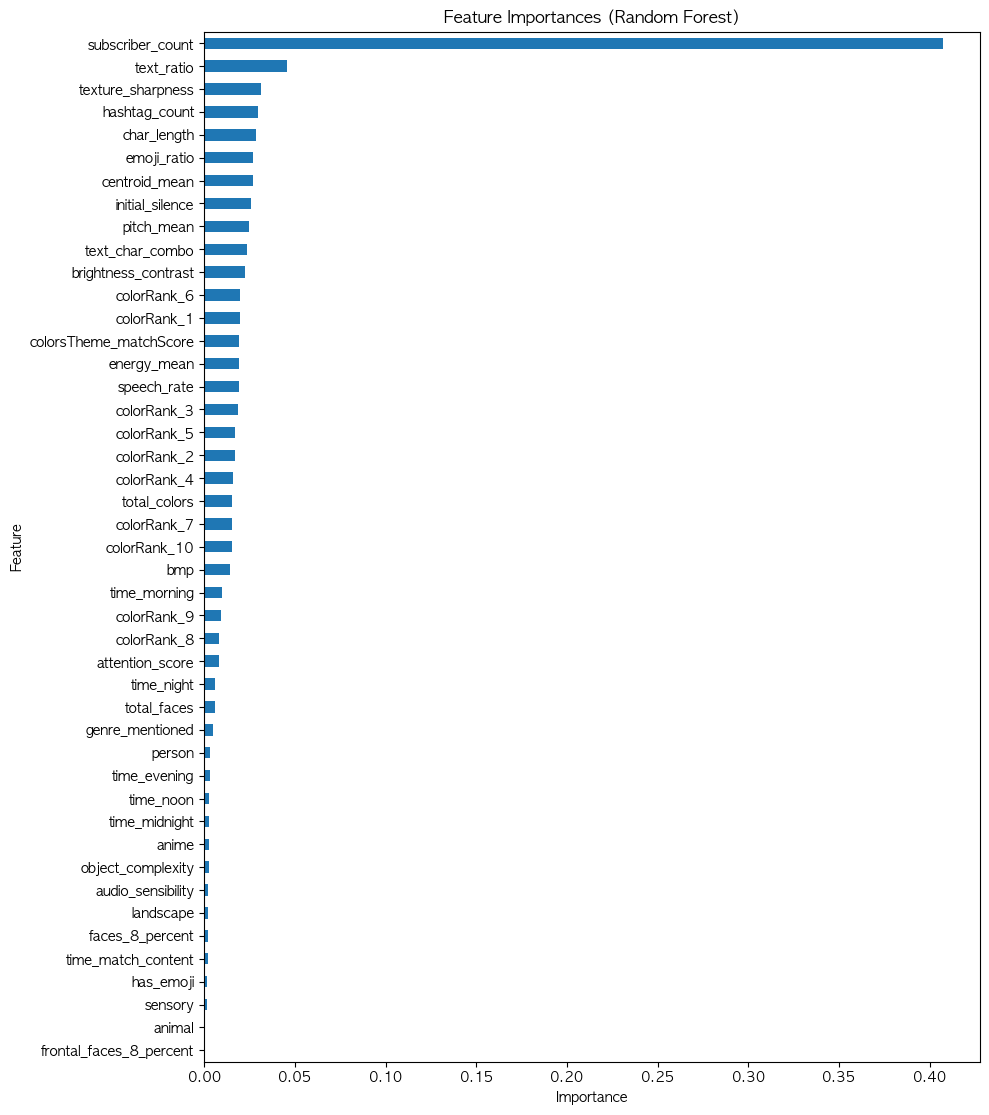

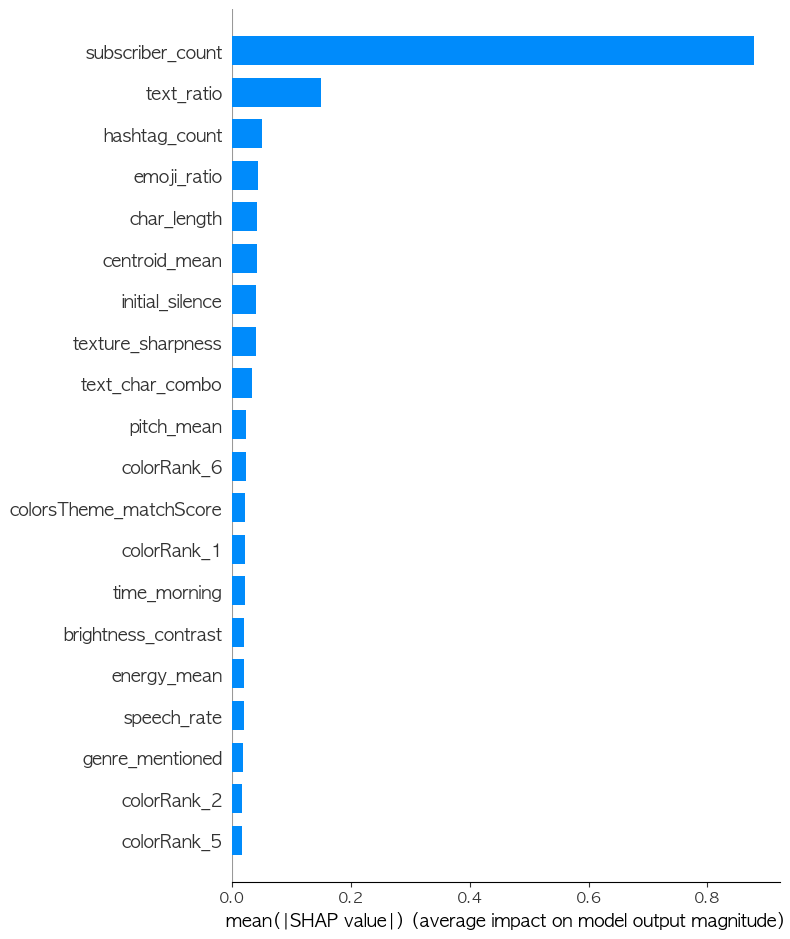

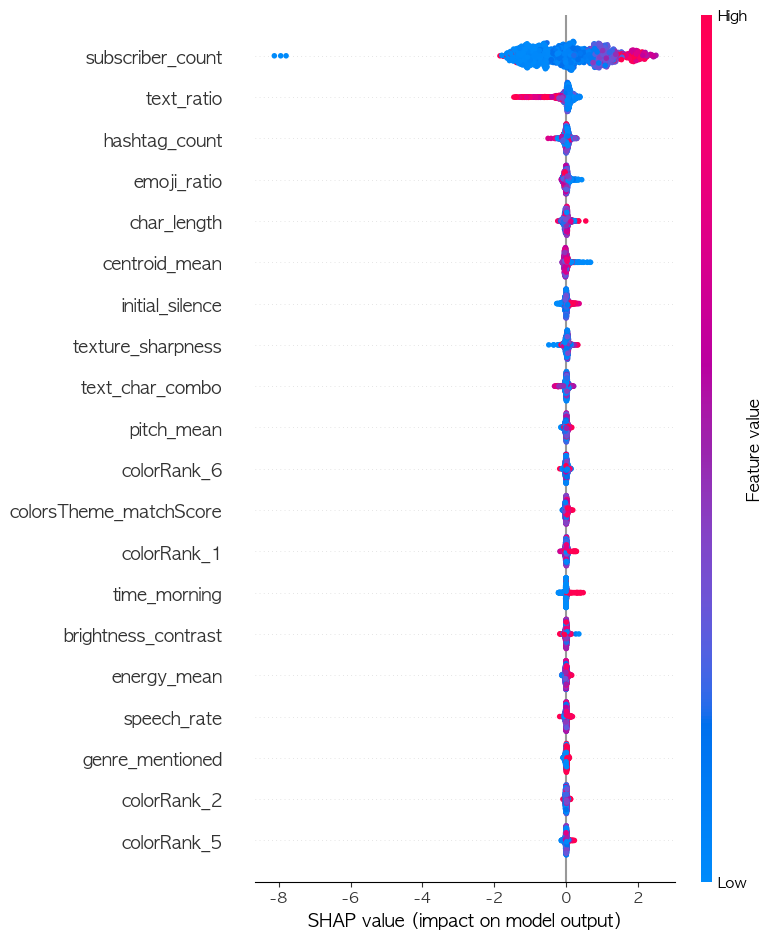

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. 모델 학습
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# 2. 테스트 성능 평가
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("🔍 Test 성능:")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# 3. Feature Importance 시각화
importances = model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, len(feat_imp) * 0.25))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# explainer 생성
explainer = shap.TreeExplainer(model)  # RandomForestRegressor 모델

# SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# 요약 그래프
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


# 🔍 Test 성능:
# R²   : 0.5378
# MAE  : 0.9968
# MSE  : 1.7183
# RMSE : 1.3108

# 🔍 Test 성능:
# R²   : 0.5348
# MAE  : 1.0027
# MSE  : 1.7295
# RMSE : 1.3151

### XGBoost

🔍 XGBoost Test 성능:
R²   : 0.4569
MAE  : 1.0803
MSE  : 2.0190
RMSE : 1.4209


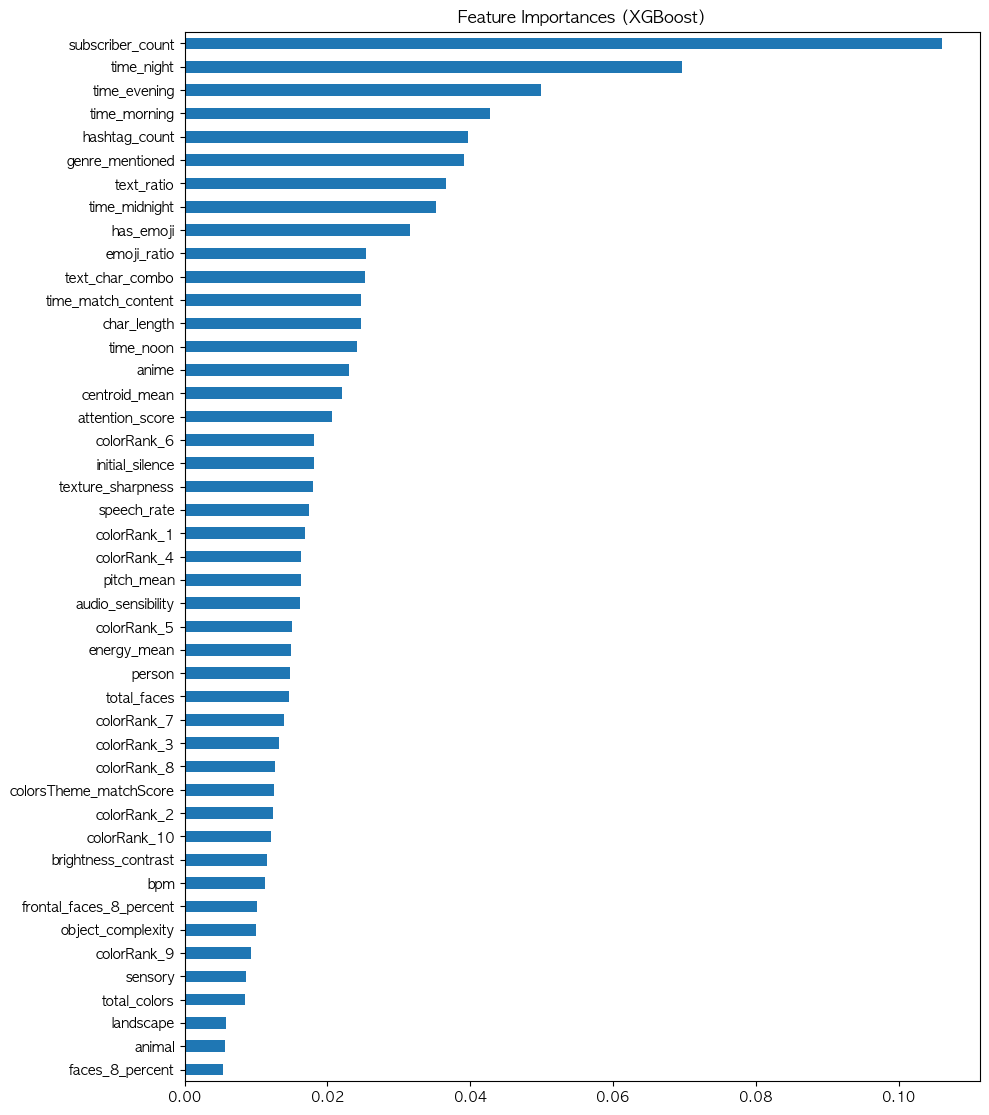

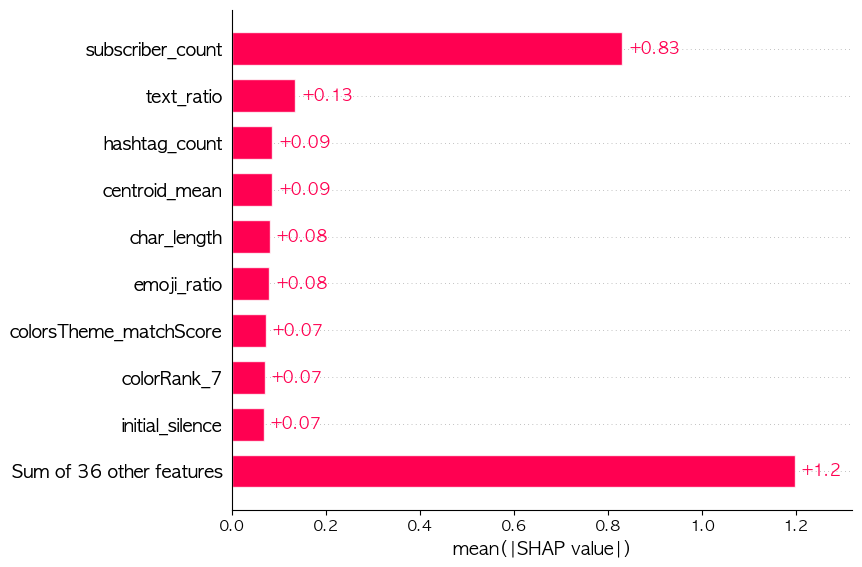

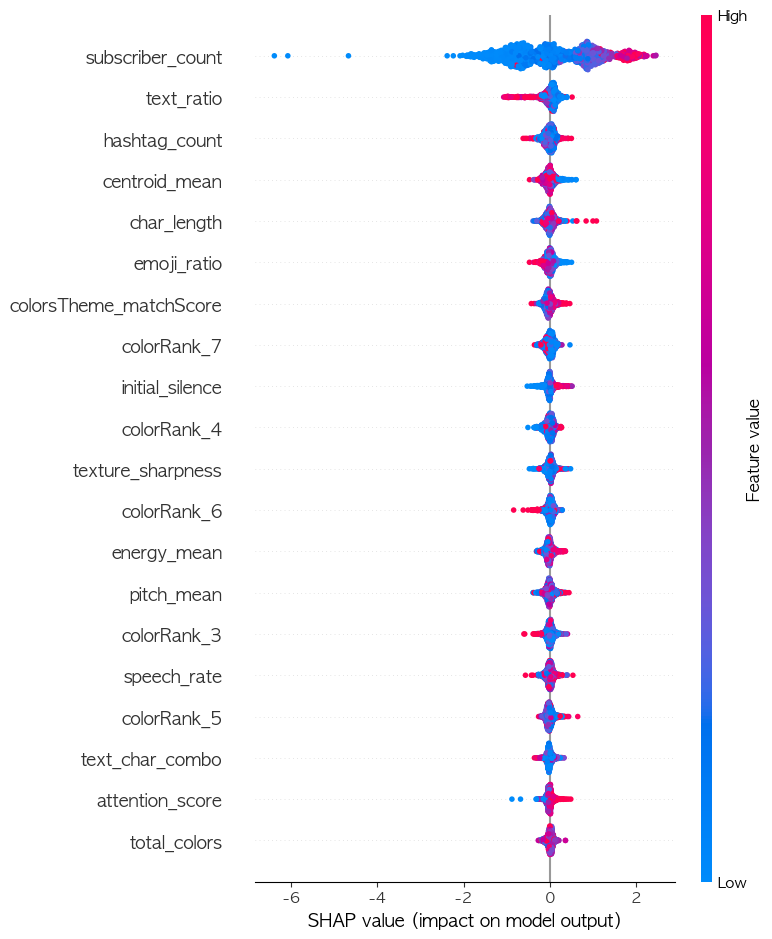

In [64]:
# XGBoost

# 1. 모델 학습
xgb_model = xgb.XGBRegressor(n_jobs=-1, random_state=42)
xgb_model.fit(X_train, y_train)

# 2. 예측 및 평가
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("🔍 XGBoost Test 성능:")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# 3. Feature Importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(10, len(xgb_importance) * 0.25))
xgb_importance.plot(kind='barh')
plt.title("Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# 4. SHAP 값 시각화
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5776
[LightGBM] [Info] Number of data points in the train set: 5740, number of used features: 44
[LightGBM] [Info] Start training from score 8.769473
🔍 LightGBM Test 성능:
R²   : 0.5166
MAE  : 1.0543
MSE  : 1.8664
RMSE : 1.3662


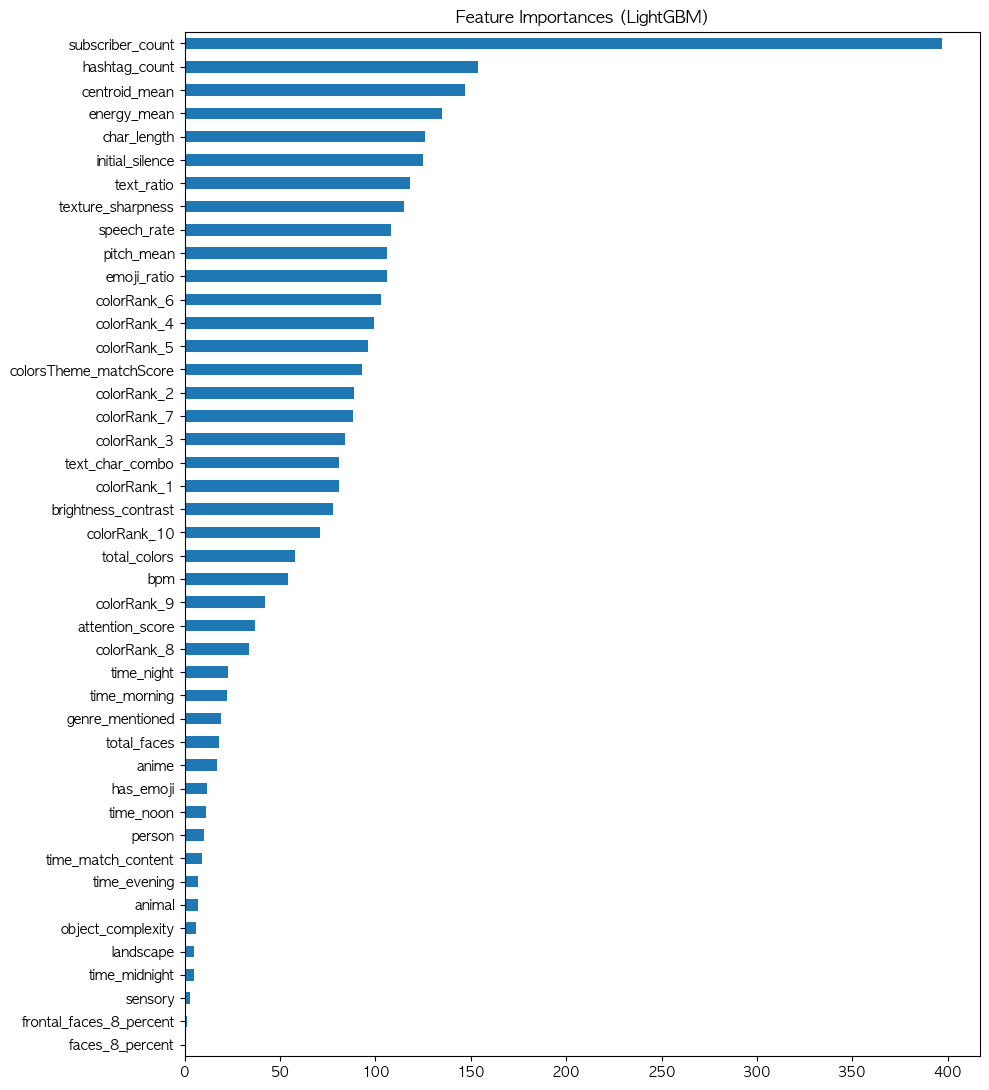

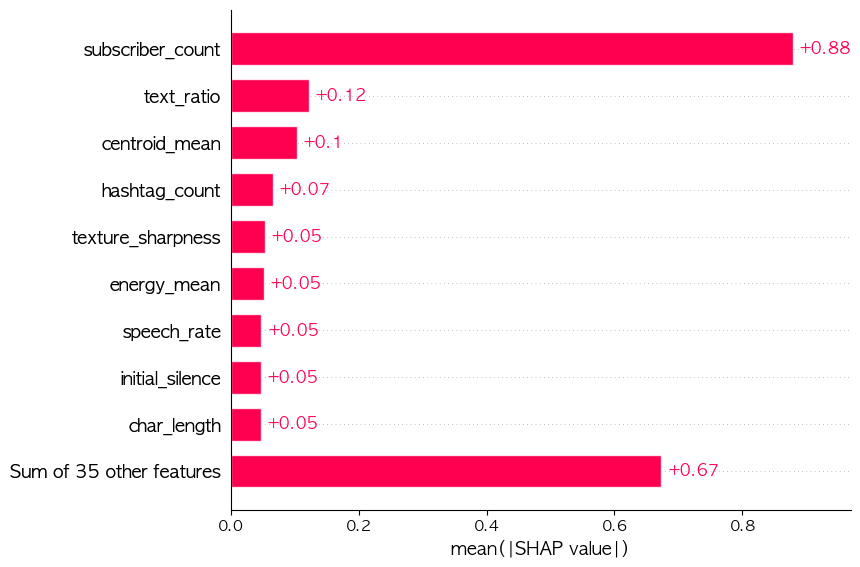

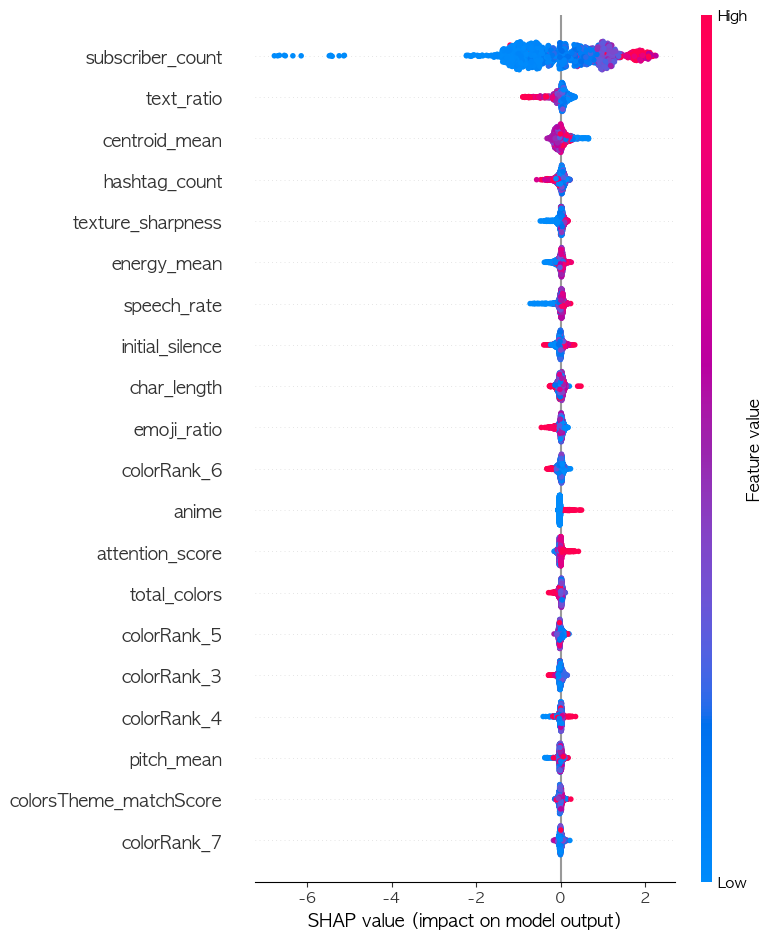

In [267]:
# LightGBM

# 1. 모델 학습
lgb_model = lgb.LGBMRegressor(n_jobs=-1, random_state=42)
lgb_model.fit(X_train, y_train)

# 2. 예측 및 평가
y_pred = lgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("🔍 LightGBM Test 성능:")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# 3. Feature Importance
lgb_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(10, len(lgb_importance) * 0.25))
lgb_importance.plot(kind='barh')
plt.title("Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

# 4. SHAP 값 시각화
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test)


## Optuna

### RandomForest

In [53]:
# RandomForest

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    return -1 * scores.mean()  # minimize MSE

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print(study.best_params)


[I 2025-06-15 23:00:07,799] A new study created in memory with name: no-name-519f7c26-4a28-4869-ac30-09051468c3c0
[I 2025-06-15 23:00:10,453] Trial 0 finished with value: 3.960003744464822 and parameters: {'n_estimators': 399, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 3.960003744464822.
[I 2025-06-15 23:00:11,745] Trial 1 finished with value: 4.433356652746992 and parameters: {'n_estimators': 331, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.960003744464822.
[I 2025-06-15 23:00:13,736] Trial 2 finished with value: 3.845703764525159 and parameters: {'n_estimators': 287, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 3.845703764525159.
[I 2025-06-15 23:00:18,761] Trial 3 finished with value: 3.6540045193457 and parameters: {'n_estimators': 156, 'max_depth': 25, 'min_sampl

{'n_estimators': 401, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}


In [54]:
study.best_params

{'n_estimators': 401,
 'max_depth': 36,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': None}

🔍 Test 성능:
R²   : 0.2884
MAE  : 1.4882
MSE  : 3.7128
RMSE : 1.9269


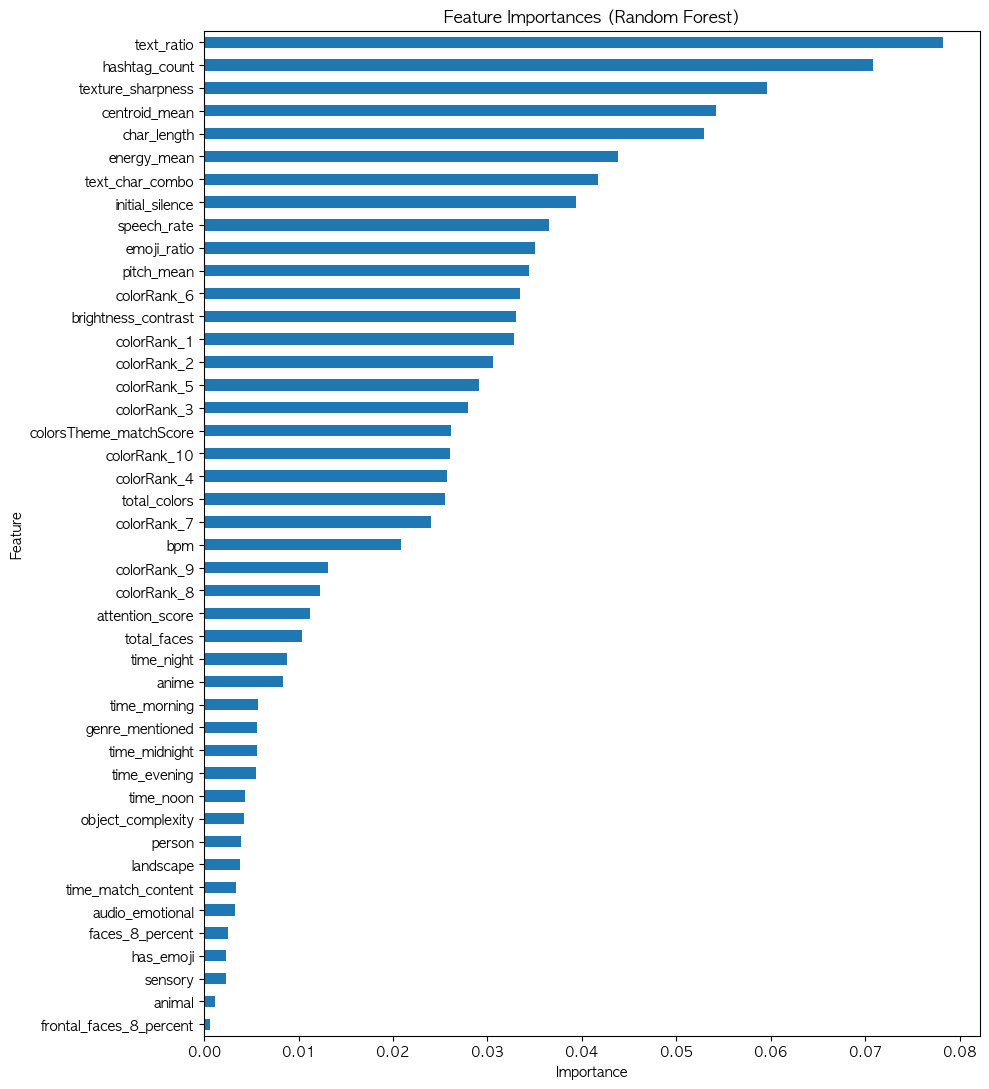

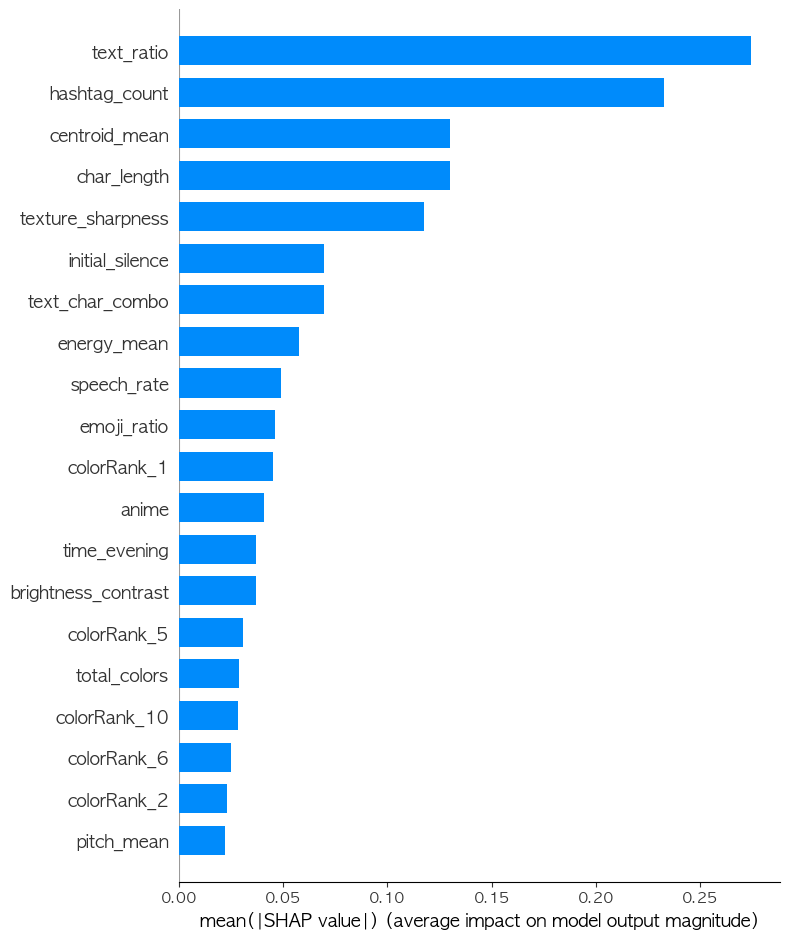

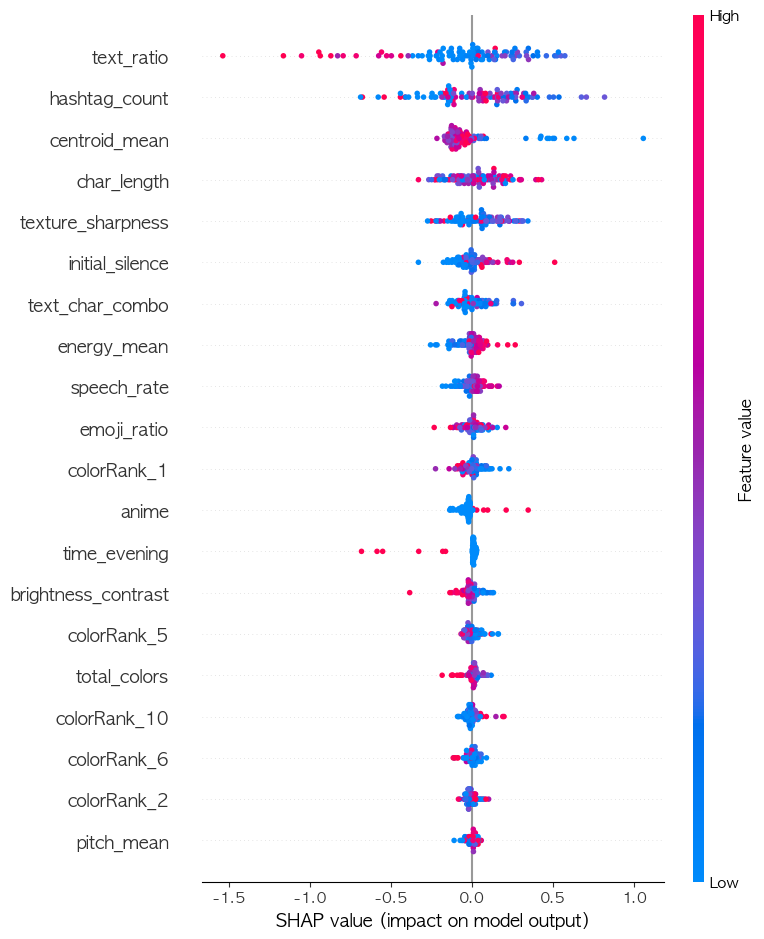

In [55]:

# 1. 최적 모델 훈련
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, n_jobs=-1, random_state=42)
best_model.fit(X_train, y_train)

# 2. 예측 및 평가
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("🔍 Test 성능:")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# 3. Feature Importance
importances = best_model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)
plt.figure(figsize=(10, len(feat_imp) * 0.25))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 4. SHAP 값 계산
explainer = shap.TreeExplainer(best_model)
X_test_sample = X_test.sample(100, random_state=42)  # 전체가 크면 샘플링 추천
shap_values = explainer.shap_values(X_test_sample)

# 5. SHAP 요약 그래프
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")
shap.summary_plot(shap_values, X_test_sample)


### XGBoost

In [58]:
def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    model = xgb.XGBRegressor(**params, n_jobs=-1, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    return -scores.mean()

xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=50)
print(xgb_study.best_params)


[I 2025-06-15 23:05:10,840] A new study created in memory with name: no-name-3647ed10-0c63-406d-9863-d11ffc1d2da8
[I 2025-06-15 23:05:13,756] Trial 0 finished with value: 3.6478015413568903 and parameters: {'n_estimators': 224, 'max_depth': 11, 'learning_rate': 0.09725961310586244, 'subsample': 0.912652052781878, 'colsample_bytree': 0.6925758303358662}. Best is trial 0 with value: 3.6478015413568903.
[I 2025-06-15 23:05:17,333] Trial 1 finished with value: 3.864894284032091 and parameters: {'n_estimators': 258, 'max_depth': 14, 'learning_rate': 0.1275360272024734, 'subsample': 0.646821607427389, 'colsample_bytree': 0.5118236449831552}. Best is trial 0 with value: 3.6478015413568903.
[I 2025-06-15 23:05:19,689] Trial 2 finished with value: 3.882232736939996 and parameters: {'n_estimators': 106, 'max_depth': 14, 'learning_rate': 0.16992483730001826, 'subsample': 0.7911658876621419, 'colsample_bytree': 0.5481862341659698}. Best is trial 0 with value: 3.6478015413568903.
[I 2025-06-15 23:0

{'n_estimators': 410, 'max_depth': 10, 'learning_rate': 0.012669982884778054, 'subsample': 0.7095886632672691, 'colsample_bytree': 0.9420012692131666}



🔍 XGBoost Test 성능:
R²   : 0.2957
MAE  : 1.4824
MSE  : 3.6749
RMSE : 1.9170


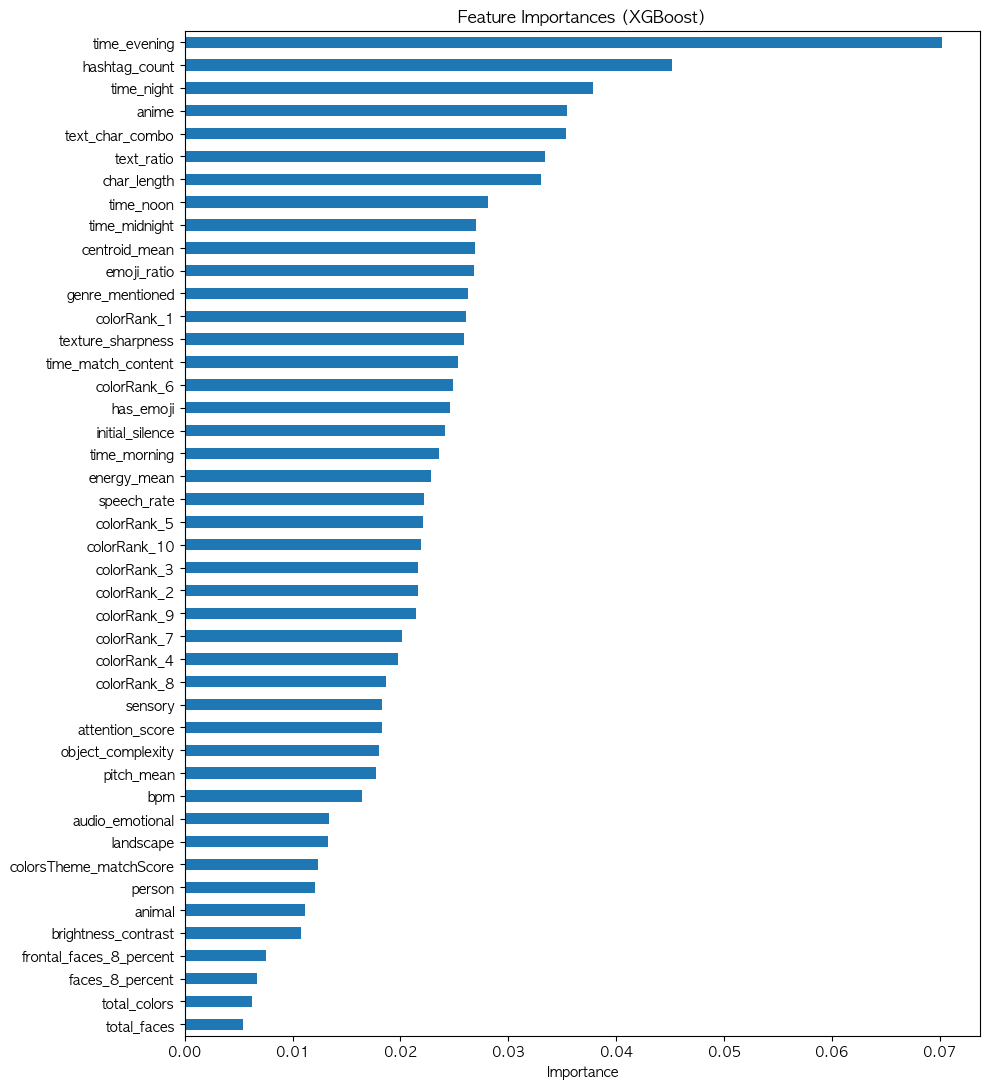

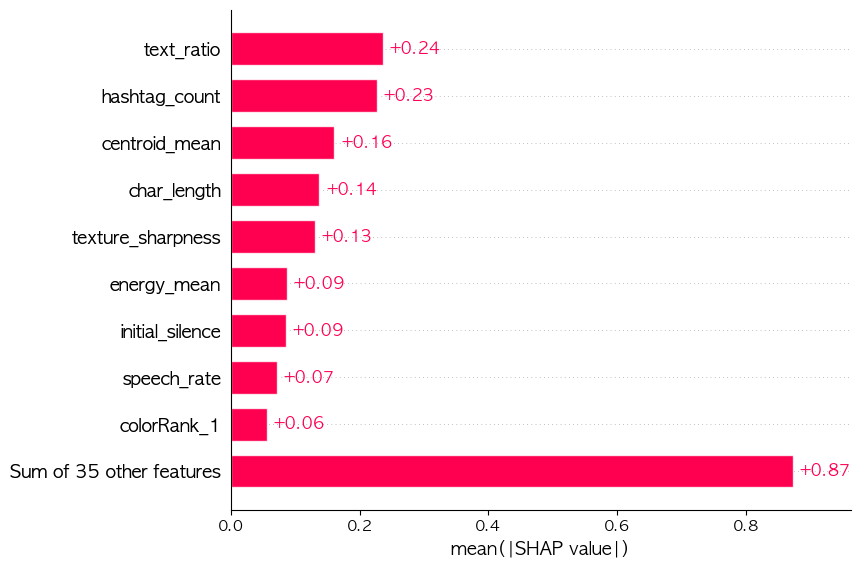

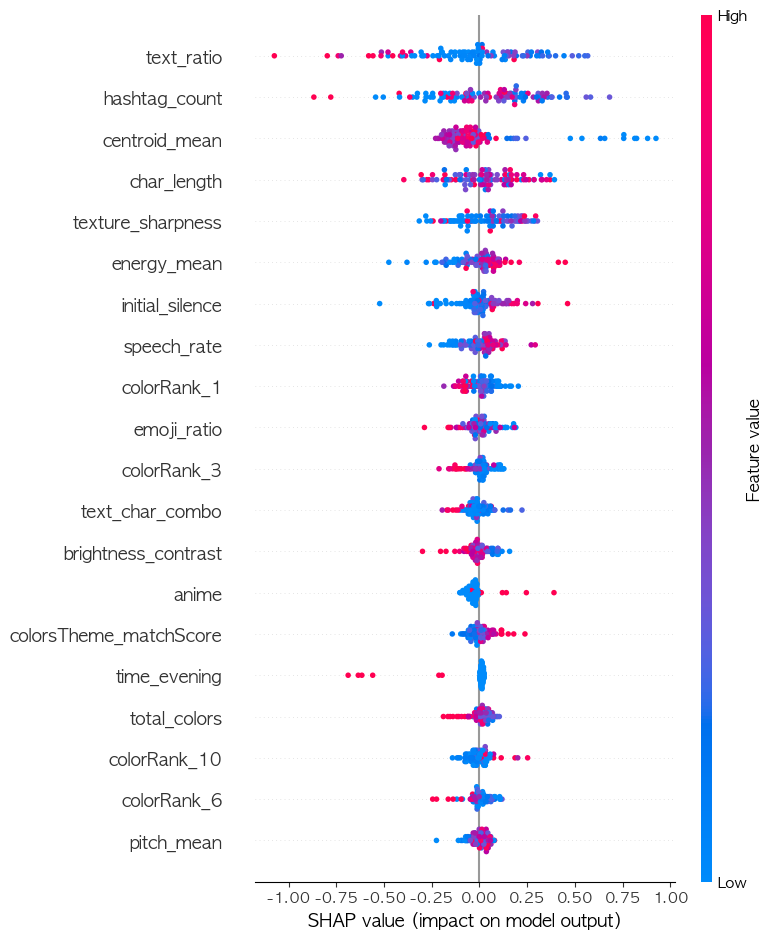

In [59]:

# 훈련
xgb_model = xgb.XGBRegressor(**xgb_study.best_params, n_jobs=-1, random_state=42)
xgb_model.fit(X_train, y_train)

# 평가
y_pred = xgb_model.predict(X_test)
print("\n🔍 XGBoost Test 성능:")
print(f"R²   : {r2_score(y_test, y_pred):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Feature Importance
feat_imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(10, len(feat_imp) * 0.25))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test.sample(100, random_state=42))
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))


### LightGBM

In [61]:

def lgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }
    model = lgb.LGBMRegressor(**params, n_jobs=-1, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    return -scores.mean()

lgb_study = optuna.create_study(direction="minimize")
lgb_study.optimize(lgb_objective, n_trials=50)
print(lgb_study.best_params)



[I 2025-06-15 23:08:50,541] A new study created in memory with name: no-name-222ead58-d1de-401e-a567-278f66a5c49a


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Total Bins 5488
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] S

[I 2025-06-15 23:08:55,859] Trial 0 finished with value: 4.1034366393723 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.25861573578484176, 'subsample': 0.8310056121886771, 'colsample_bytree': 0.9270714916779538}. Best is trial 0 with value: 4.1034366393723.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5489[LightGBM] [Info] Total Bins 5528

[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.305013
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set

[I 2025-06-15 23:09:01,028] Trial 1 finished with value: 4.166611764140793 and parameters: {'n_estimators': 255, 'max_depth': 9, 'learning_rate': 0.28208753974788114, 'subsample': 0.9843434912661193, 'colsample_bytree': 0.5450359279800303}. Best is trial 0 with value: 4.1034366393723.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

[I 2025-06-15 23:09:02,149] Trial 2 finished with value: 4.051788566517024 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.28045689082139186, 'subsample': 0.6494751900913791, 'colsample_bytree': 0.9060776501924278}. Best is trial 2 with value: 4.051788566517024.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from

[I 2025-06-15 23:09:06,268] Trial 3 finished with value: 3.9244583227612266 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.20795385018778612, 'subsample': 0.5428852241528664, 'colsample_bytree': 0.6291369426476678}. Best is trial 3 with value: 3.9244583227612266.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.305013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

[I 2025-06-15 23:09:09,842] Trial 4 finished with value: 3.804033632652512 and parameters: {'n_estimators': 207, 'max_depth': 8, 'learning_rate': 0.12448126840474534, 'subsample': 0.6087132868337137, 'colsample_bytree': 0.8542692495058171}. Best is trial 4 with value: 3.804033632652512.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.305013
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5488
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:09:16,088] Trial 5 finished with value: 3.803900006220462 and parameters: {'n_estimators': 323, 'max_depth': 10, 'learning_rate': 0.11208811199677611, 'subsample': 0.9863008751661159, 'colsample_bytree': 0.9085919357077114}. Best is trial 5 with value: 3.803900006220462.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00156

[I 2025-06-15 23:09:18,244] Trial 6 finished with value: 3.7318249925943463 and parameters: {'n_estimators': 129, 'max_depth': 7, 'learning_rate': 0.06433678368824998, 'subsample': 0.5558943663658125, 'colsample_bytree': 0.7739466386311382}. Best is trial 6 with value: 3.7318249925943463.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-15 23:09:20,459] Trial 7 finished with value: 3.852373740176587 and parameters: {'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.16758471727525548, 'subsample': 0.5564504683267328, 'colsample_bytree': 0.9317479975525855}. Best is trial 6 with value: 3.7318249925943463.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features:

[I 2025-06-15 23:09:27,430] Trial 8 finished with value: 3.8328899420124656 and parameters: {'n_estimators': 325, 'max_depth': 11, 'learning_rate': 0.15312061083195447, 'subsample': 0.5958038597690309, 'colsample_bytree': 0.5027747284849398}. Best is trial 6 with value: 3.7318249925943463.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:09:31,634] Trial 9 finished with value: 3.837638698977865 and parameters: {'n_estimators': 180, 'max_depth': 14, 'learning_rate': 0.016139787193729167, 'subsample': 0.9406466077880995, 'colsample_bytree': 0.5016569319695685}. Best is trial 6 with value: 3.7318249925943463.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosi

[I 2025-06-15 23:09:33,429] Trial 10 finished with value: 3.9885660720344362 and parameters: {'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.036337037589147886, 'subsample': 0.7188572893806461, 'colsample_bytree': 0.7476993336457646}. Best is trial 6 with value: 3.7318249925943463.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-15 23:09:40,347] Trial 11 finished with value: 3.720267306935991 and parameters: {'n_estimators': 339, 'max_depth': 13, 'learning_rate': 0.08137888762338916, 'subsample': 0.8348521276651136, 'colsample_bytree': 0.7951780559720887}. Best is trial 11 with value: 3.720267306935991.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:09:48,413] Trial 12 finished with value: 3.702305423855421 and parameters: {'n_estimators': 417, 'max_depth': 15, 'learning_rate': 0.06685117777530447, 'subsample': 0.8281415705399136, 'colsample_bytree': 0.7694028015775017}. Best is trial 12 with value: 3.702305423855421.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-06-15 23:09:55,615] Trial 13 finished with value: 3.7186147086778667 and parameters: {'n_estimators': 406, 'max_depth': 15, 'learning_rate': 0.07919284538425637, 'subsample': 0.8356256554980581, 'colsample_bytree': 0.7406328253749143}. Best is trial 12 with value: 3.702305423855421.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 9.305013
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:10:03,952] Trial 14 finished with value: 3.7229213532599297 and parameters: {'n_estimators': 436, 'max_depth': 15, 'learning_rate': 0.07358215663675487, 'subsample': 0.8461870844378622, 'colsample_bytree': 0.6848474851063499}. Best is trial 12 with value: 3.702305423855421.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:10:11,657] Trial 15 finished with value: 3.792779315502462 and parameters: {'n_estimators': 401, 'max_depth': 12, 'learning_rate': 0.09664509995778432, 'subsample': 0.7513916941746266, 'colsample_bytree': 0.6785076474702304}. Best is trial 12 with value: 3.702305423855421.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2025-06-15 23:10:21,103] Trial 16 finished with value: 3.6857557768304274 and parameters: {'n_estimators': 487, 'max_depth': 15, 'learning_rate': 0.04650811331414839, 'subsample': 0.8934292596722124, 'colsample_bytree': 0.8293856274106277}. Best is trial 16 with value: 3.6857557768304274.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:10:30,985] Trial 17 finished with value: 3.7489923951804984 and parameters: {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.010128592706076099, 'subsample': 0.918541671154891, 'colsample_bytree': 0.8276539272350267}. Best is trial 16 with value: 3.6857557768304274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:10:40,238] Trial 18 finished with value: 3.691354312264606 and parameters: {'n_estimators': 498, 'max_depth': 15, 'learning_rate': 0.04473482107835755, 'subsample': 0.7592641716526893, 'colsample_bytree': 0.8461422579263211}. Best is trial 16 with value: 3.6857557768304274.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:10:49,837] Trial 19 finished with value: 3.738314015397708 and parameters: {'n_estimators': 499, 'max_depth': 13, 'learning_rate': 0.046422170985355296, 'subsample': 0.7609721608278474, 'colsample_bytree': 0.969250303234985}. Best is trial 16 with value: 3.6857557768304274.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise

[I 2025-06-15 23:10:53,645] Trial 20 finished with value: 3.8387189133137896 and parameters: {'n_estimators': 361, 'max_depth': 5, 'learning_rate': 0.139675530164808, 'subsample': 0.895588703225051, 'colsample_bytree': 0.8651183828488211}. Best is trial 16 with value: 3.6857557768304274.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-15 23:11:02,077] Trial 21 finished with value: 3.6978525523632952 and parameters: {'n_estimators': 470, 'max_depth': 15, 'learning_rate': 0.044114252891010466, 'subsample': 0.6928031877304244, 'colsample_bytree': 0.8031740148344679}. Best is trial 16 with value: 3.6857557768304274.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:11:10,859] Trial 22 finished with value: 3.670270111326758 and parameters: {'n_estimators': 464, 'max_depth': 14, 'learning_rate': 0.03680458542215472, 'subsample': 0.6919541272037741, 'colsample_bytree': 0.837101910810379}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:11:19,553] Trial 23 finished with value: 3.9334225040086492 and parameters: {'n_estimators': 469, 'max_depth': 14, 'learning_rate': 0.1915828898514662, 'subsample': 0.783906035887511, 'colsample_bytree': 0.9973289590756989}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:11:27,324] Trial 24 finished with value: 3.6882303395072773 and parameters: {'n_estimators': 388, 'max_depth': 12, 'learning_rate': 0.02892791266688436, 'subsample': 0.6787215768232663, 'colsample_bytree': 0.8809414658233554}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003281 seconds.


[I 2025-06-15 23:11:34,930] Trial 25 finished with value: 3.6863019229827203 and parameters: {'n_estimators': 375, 'max_depth': 12, 'learning_rate': 0.031398205844182944, 'subsample': 0.6682984390209731, 'colsample_bytree': 0.8806779803393272}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2025-06-15 23:11:43,979] Trial 26 finished with value: 3.764549490842872 and parameters: {'n_estimators': 443, 'max_depth': 12, 'learning_rate': 0.09500511626811997, 'subsample': 0.6436287590747195, 'colsample_bytree': 0.7179688371958868}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Number of data points in the 

[I 2025-06-15 23:11:51,019] Trial 27 finished with value: 3.708815761880831 and parameters: {'n_estimators': 373, 'max_depth': 14, 'learning_rate': 0.05181988975464259, 'subsample': 0.7137741081921714, 'colsample_bytree': 0.8242653261129644}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] S

[I 2025-06-15 23:11:56,821] Trial 28 finished with value: 3.826674052816697 and parameters: {'n_estimators': 280, 'max_depth': 11, 'learning_rate': 0.011530589428252469, 'subsample': 0.7920812698629505, 'colsample_bytree': 0.9432339534656744}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:12:05,118] Trial 29 finished with value: 4.050883261103843 and parameters: {'n_estimators': 468, 'max_depth': 11, 'learning_rate': 0.23770969429565428, 'subsample': 0.506272399041989, 'colsample_bytree': 0.8955023031543837}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

[I 2025-06-15 23:12:13,540] Trial 30 finished with value: 3.802963660656144 and parameters: {'n_estimators': 429, 'max_depth': 13, 'learning_rate': 0.10596047895266203, 'subsample': 0.6483873813498684, 'colsample_bytree': 0.8095867066125428}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:12:21,417] Trial 31 finished with value: 3.6946869844029053 and parameters: {'n_estimators': 385, 'max_depth': 12, 'learning_rate': 0.023579644778126706, 'subsample': 0.685065750892015, 'colsample_bytree': 0.8811109984584531}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:12:27,982] Trial 32 finished with value: 3.697067785908657 and parameters: {'n_estimators': 345, 'max_depth': 10, 'learning_rate': 0.02756844034498394, 'subsample': 0.670159165227692, 'colsample_bytree': 0.8637700955425214}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:12:33,511] Trial 33 finished with value: 3.726411392691998 and parameters: {'n_estimators': 292, 'max_depth': 12, 'learning_rate': 0.05891312480604421, 'subsample': 0.715952772983488, 'colsample_bytree': 0.9455659188865658}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:12:40,928] Trial 34 finished with value: 3.7007584692253475 and parameters: {'n_estimators': 384, 'max_depth': 14, 'learning_rate': 0.03460109073423382, 'subsample': 0.6222543655803503, 'colsample_bytree': 0.9072292674486943}. Best is trial 22 with value: 3.670270111326758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:12:49,825] Trial 35 finished with value: 3.6616053875463783 and parameters: {'n_estimators': 458, 'max_depth': 10, 'learning_rate': 0.03154180301060433, 'subsample': 0.5882915501260402, 'colsample_bytree': 0.8388132922284323}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-06-15 23:12:57,382] Trial 36 finished with value: 4.163060354172814 and parameters: {'n_estimators': 463, 'max_depth': 9, 'learning_rate': 0.29159226281106526, 'subsample': 0.5913175094448133, 'colsample_bytree': 0.8421229880440867}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

[I 2025-06-15 23:13:06,713] Trial 37 finished with value: 3.771796814219811 and parameters: {'n_estimators': 484, 'max_depth': 10, 'learning_rate': 0.12026979022568797, 'subsample': 0.5756714758408588, 'colsample_bytree': 0.6172143890037546}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise

[I 2025-06-15 23:13:13,548] Trial 38 finished with value: 3.7112283955850387 and parameters: {'n_estimators': 420, 'max_depth': 9, 'learning_rate': 0.0578640017301896, 'subsample': 0.6378402696833334, 'colsample_bytree': 0.7934666746950327}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_row_wise=true` to remo

[I 2025-06-15 23:13:20,554] Trial 39 finished with value: 3.7431185906660347 and parameters: {'n_estimators': 451, 'max_depth': 8, 'learning_rate': 0.08152159321561128, 'subsample': 0.5313077208569419, 'colsample_bytree': 0.7685807089236272}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set

[I 2025-06-15 23:13:25,282] Trial 40 finished with value: 4.07856609139762 and parameters: {'n_estimators': 249, 'max_depth': 11, 'learning_rate': 0.25067344834951677, 'subsample': 0.8697386439148503, 'colsample_bytree': 0.9181603709521802}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:13:33,105] Trial 41 finished with value: 3.69082429918211 and parameters: {'n_estimators': 397, 'max_depth': 13, 'learning_rate': 0.027687704047991146, 'subsample': 0.6715406212603278, 'colsample_bytree': 0.8719213561692961}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-06-15 23:13:39,679] Trial 42 finished with value: 3.7007250806802494 and parameters: {'n_estimators': 363, 'max_depth': 14, 'learning_rate': 0.029599177097975955, 'subsample': 0.6144536311921104, 'colsample_bytree': 0.8883043875376261}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-06-15 23:13:47,421] Trial 43 finished with value: 3.6870835815837366 and parameters: {'n_estimators': 428, 'max_depth': 12, 'learning_rate': 0.043353372429481986, 'subsample': 0.7245215330894277, 'colsample_bytree': 0.8358280008232577}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start traini

[I 2025-06-15 23:13:56,567] Trial 44 finished with value: 3.7090106490025185 and parameters: {'n_estimators': 479, 'max_depth': 11, 'learning_rate': 0.06299819925947511, 'subsample': 0.7306231971348661, 'colsample_bytree': 0.8267311638031136}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:14:05,193] Trial 45 finished with value: 3.698858423644296 and parameters: {'n_estimators': 452, 'max_depth': 10, 'learning_rate': 0.04261124263248141, 'subsample': 0.7902228372469283, 'colsample_bytree': 0.8490501331952255}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5489
[LightGBM] [Info] Number of data points in the train set: 

[I 2025-06-15 23:14:13,468] Trial 46 finished with value: 3.7495378254431 and parameters: {'n_estimators': 421, 'max_depth': 14, 'learning_rate': 0.08755944866096221, 'subsample': 0.9618517470521762, 'colsample_bytree': 0.781610909803944}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.


[I 2025-06-15 23:14:19,312] Trial 47 finished with value: 3.771258192162197 and parameters: {'n_estimators': 434, 'max_depth': 6, 'learning_rate': 0.018196165496472603, 'subsample': 0.7013502058175121, 'colsample_bytree': 0.714532607651663}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-15 23:14:27,554] Trial 48 finished with value: 3.738016194464584 and parameters: {'n_estimators': 410, 'max_depth': 13, 'learning_rate': 0.06503902767586178, 'subsample': 0.7413773860470517, 'colsample_bytree': 0.8226905963765421}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5483
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.256150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 4368, number of used features: 44
[LightGBM] [Info] Start training from score 9.311189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2025-06-15 23:14:33,182] Trial 49 finished with value: 3.890310533899983 and parameters: {'n_estimators': 315, 'max_depth': 12, 'learning_rate': 0.17854045661606954, 'subsample': 0.9994567853997769, 'colsample_bytree': 0.7582646093900487}. Best is trial 35 with value: 3.6616053875463783.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
{'n_estimators': 458, 'max_depth': 10, 'learning_rate': 0.03154180301060433, 'subsample': 0.5882915501260402, 'colsample_bytree': 0.8388132922284323}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5546
[LightGBM] [Info] Number of data points in the train set: 5460, number of used features: 44
[LightGBM] [Info] Start training from score 9.289167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

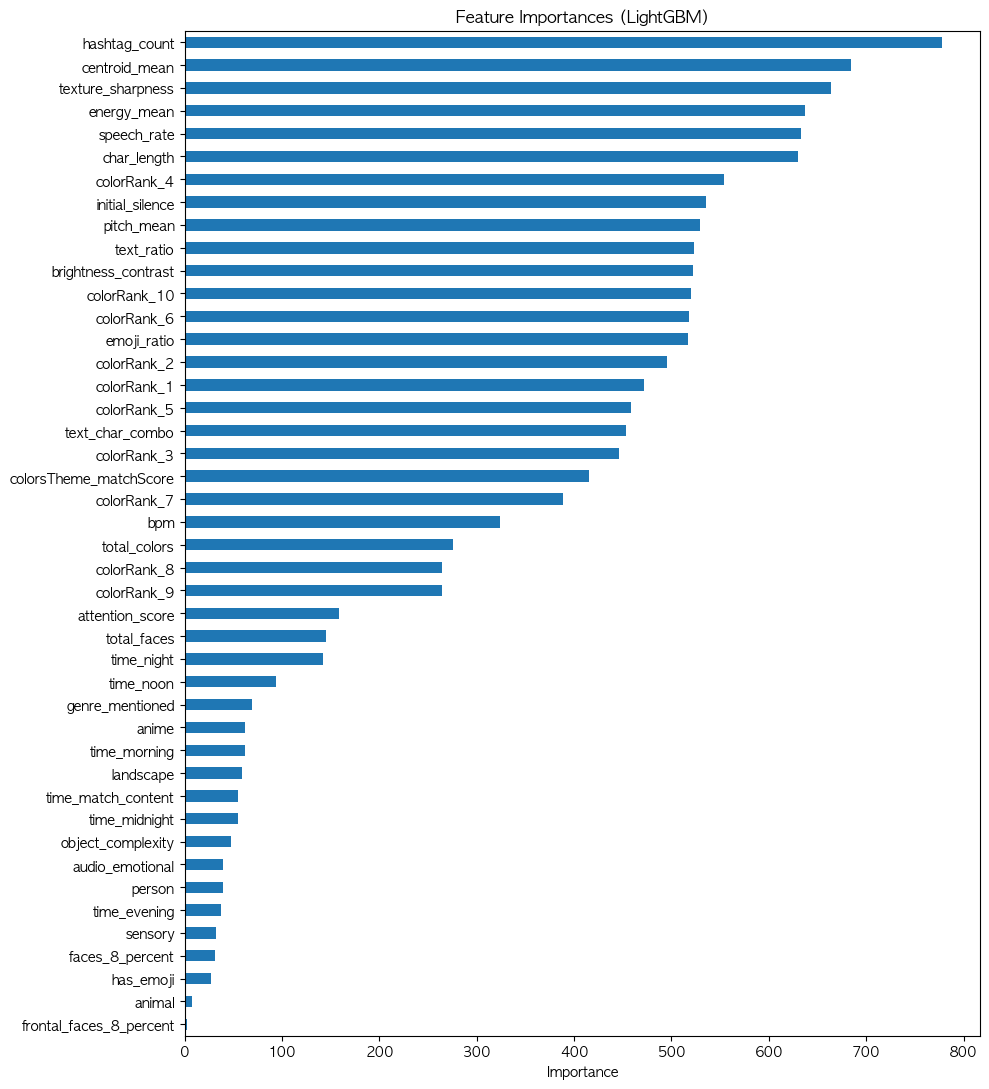

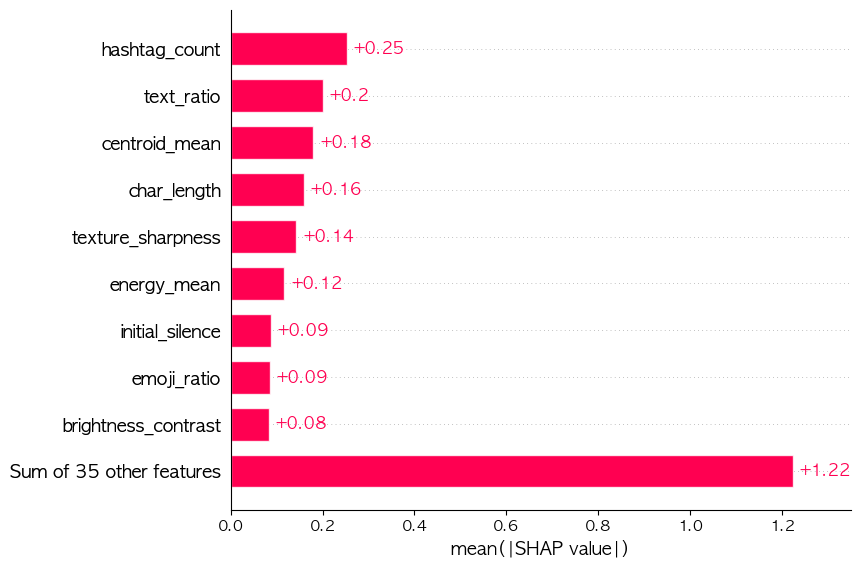

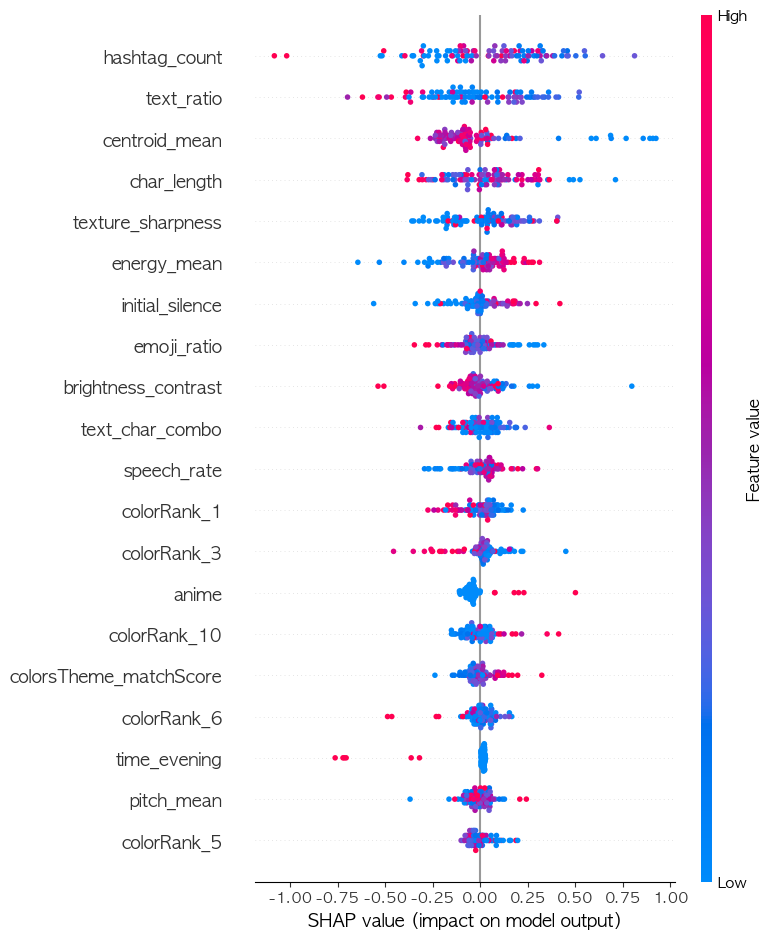

In [62]:

# 훈련
lgb_model = lgb.LGBMRegressor(**lgb_study.best_params, n_jobs=-1, random_state=42)
lgb_model.fit(X_train, y_train)

# 평가
y_pred = lgb_model.predict(X_test)
print("\n🔍 LightGBM Test 성능:")
print(f"R²   : {r2_score(y_test, y_pred):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Feature Importance
feat_imp = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(10, len(feat_imp) * 0.25))
feat_imp.plot(kind='barh')
plt.title("Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# SHAP
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_test.sample(100, random_state=42))
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))

In [63]:
import pickle
import os

# 저장 폴더 생성
os.makedirs("optuna_pkl", exist_ok=True)

# RandomForest 저장
file_name = "optuna_pkl/rf_optuna_model_withoutSubs.pkl"
pickle.dump(best_model, open(file_name, "wb"))

# XGBoost 저장
file_name = "optuna_pkl/xgb_optuna_model_withoutSubs.pkl"
pickle.dump(xgb_model, open(file_name, "wb"))

# LightGBM 저장
file_name = "optuna_pkl/lgb_optuna_model_withoutSubs.pkl"
pickle.dump(lgb_model, open(file_name, "wb"))

print("✅ 이상치 상위 10% 제거 후 모델 저장 완료")


✅ 이상치 상위 10% 제거 후 모델 저장 완료


## 모델 불러와서 SHAP VALUE 출력


📊 SHAP Summary Plot (Rank 1 ~ 10)


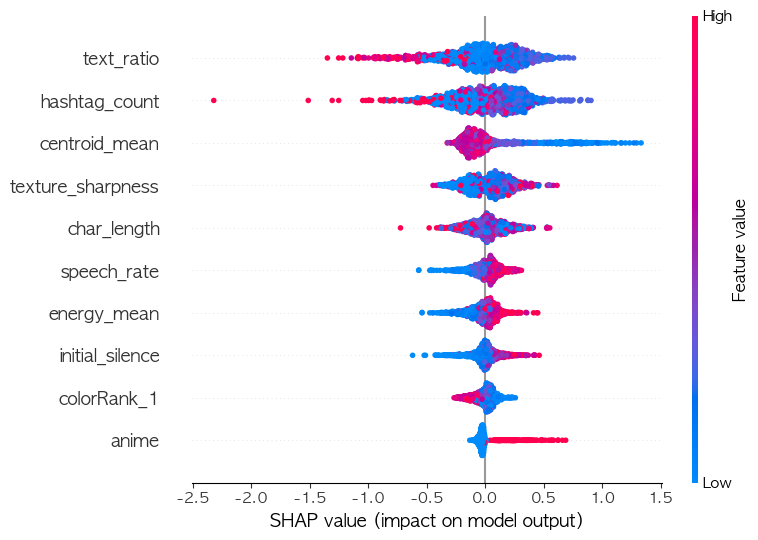


📊 SHAP Summary Plot (Rank 11 ~ 20)


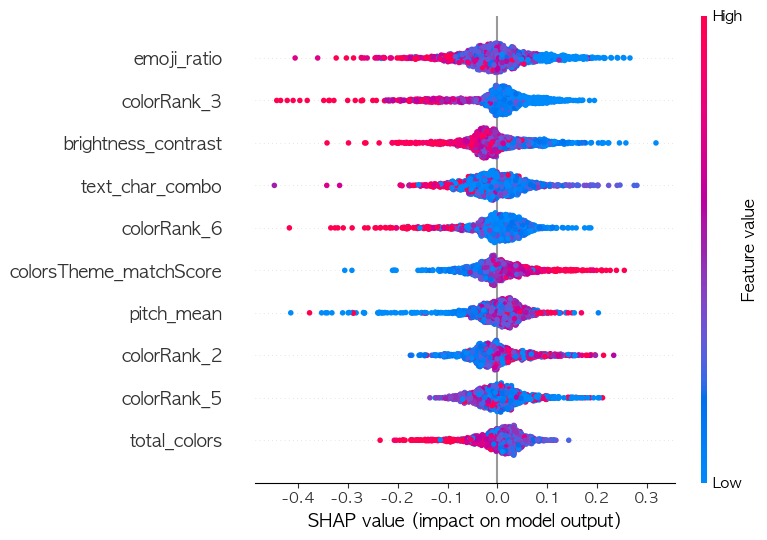


📊 SHAP Summary Plot (Rank 21 ~ 30)


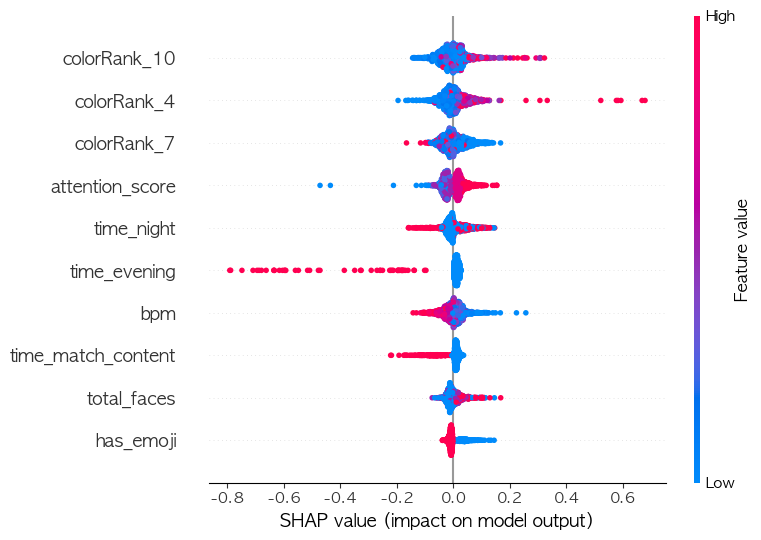


📊 SHAP Summary Plot (Rank 31 ~ 40)


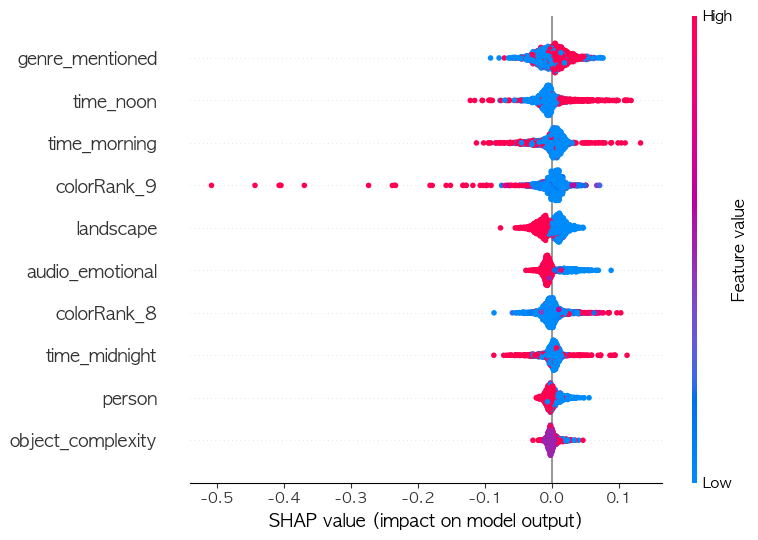

In [70]:
# 가장 성능 좋았던 XGBoost
# test 전체의 SHAP value 30개

import pickle
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1. 모델 불러오기
file_name = "optuna_pkl/xgb_optuna_model_withoutSubs.pkl"
with open(file_name, "rb") as f:
    rf_model = pickle.load(f)

# 2. SHAP explainer 생성
explainer = shap.TreeExplainer(rf_model)

# 3. SHAP 값 계산 (X_test 전체 사용)
shap_values = explainer.shap_values(X_test)

# 4. SHAP 절댓값 평균 기준 상위 30개 특성 추출
shap_abs_mean = pd.DataFrame(shap_values, columns=X_test.columns).abs().mean().sort_values(ascending=False)
top40_features = shap_abs_mean.head(40).index.tolist()

# 5. 상위 20개 특성에 해당하는 SHAP 값과 데이터 선택
shap_top40 = pd.DataFrame(shap_values, columns=X_test.columns)[top40_features]
X_top40 = X_test[top40_features]

# 6. 시각화 (x축 범위 자동)
# shap.summary_plot(shap_top30.values, X_top30, plot_type='dot', color_bar=True, show=True, max_display=30)
# SHAP 상위 30개 특성을 10개씩 나눠 시각화
for i in range(0, 40, 10):
    print(f"\n📊 SHAP Summary Plot (Rank {i+1} ~ {i+10})")
    
    features_subset = top40_features[i:i+10]
    shap_values_subset = pd.DataFrame(shap_values, columns=X_test.columns)[features_subset]
    X_subset = X_test[features_subset]

    shap.summary_plot(shap_values_subset.values, X_subset, plot_type='dot', 
                      color_bar=True, show=True, max_display=10)



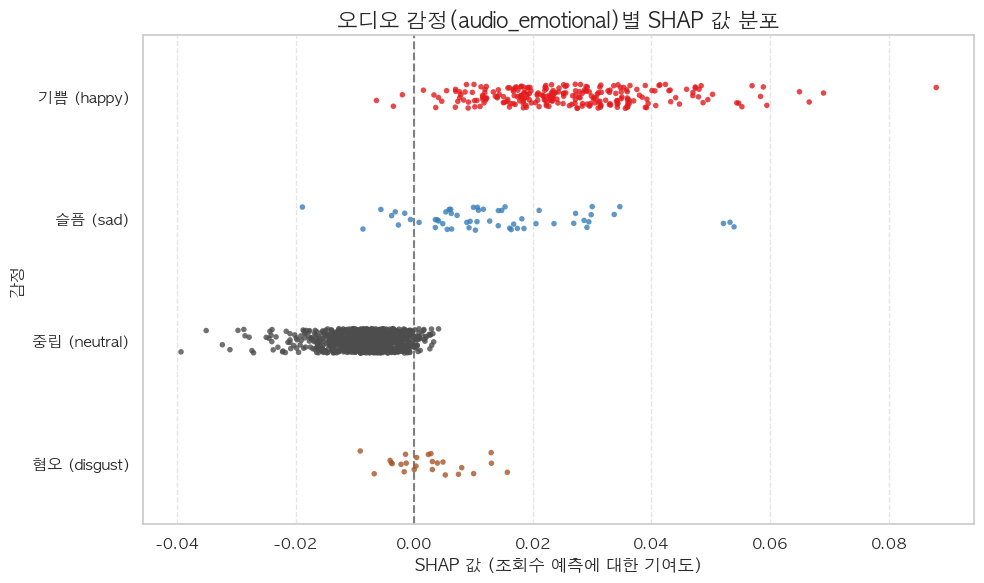

In [108]:
import pickle
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. 모델 불러오기
file_name = "optuna_pkl/xgb_optuna_model_withoutSubs.pkl"
with open(file_name, "rb") as f:
    rf_model = pickle.load(f)

# 2. SHAP 계산
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# 3. audio_emotional SHAP 값 추출
feature_name = 'audio_emotional'
col_idx = X_test.columns.get_loc(feature_name)
shap_audio = shap_values[:, col_idx]

# 4. 감정 라벨 매핑
emotion_label_map = {
    0: "기쁨 (happy)", 1: "슬픔 (sad)", 2: "분노 (angry)",
    3: "공포 (fear)", 4: "놀람 (surprise)", 5: "혐오 (disgust)", 6: "중립 (neutral)"
}

# 5. 감정별 고정 색상 지정
emotion_color_map = {
    "기쁨 (happy)": "#e41a1c",     # 빨강
    "슬픔 (sad)": "#377eb8",      # 파랑
    "분노 (angry)": "#984ea3",    # 보라
    "공포 (fear)": "#ff7f00",     # 주황
    "놀람 (surprise)": "#4daf4a", # 초록
    "혐오 (disgust)": "#a65628",  # 갈색
    "중립 (neutral)": "#4D4D4D"   # 더 진한 회색
}


# 6. 시각화용 DataFrame 생성
plot_df = pd.DataFrame({
    'emotion_label': X_test[feature_name],
    'shap_value': shap_audio
})
plot_df['emotion_name'] = plot_df['emotion_label'].map(emotion_label_map)

# 7. 샘플 수가 너무 적은 감정은 제외
plot_df = plot_df.groupby('emotion_name').filter(lambda x: len(x) >= 10)

# 8. stripplot 스타일 시각화 (색은 감정별 고정)
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=plot_df,
    y='emotion_name',
    x='shap_value',
    hue='emotion_name',
    palette=emotion_color_map,
    jitter=True,
    size=4,
    alpha=0.8,
    legend=False
)

# 9. 스타일 마무리
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("SHAP 값 (조회수 예측에 대한 기여도)", fontsize=12)
plt.ylabel("감정", fontsize=12)
plt.title("오디오 감정(audio_emotional)별 SHAP 값 분포", fontsize=15)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [67]:
ddf = pd.read_csv('../rawData/audio/audio_qualitative.csv', encoding='utf-8')
ddf['emotion_name'].value_counts()
# happy: 0, sad: 1, angry:2, fear: 3, surprise: 4, disgust: 5, neutral: 6

emotion_name
neutral    6316
happy      1670
sad         334
disgust     162
fear         20
angry         1
Name: count, dtype: int64

Pearson correlation: 0.071
Spearman correlation: 0.068


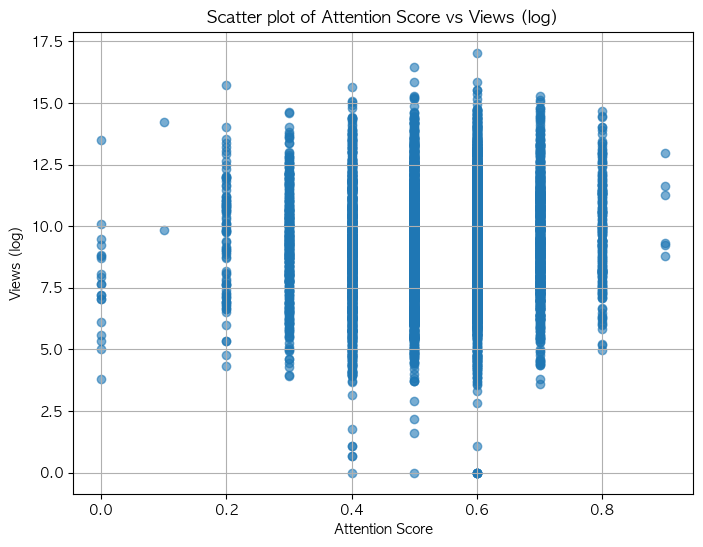

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


# 1. 결측치 제거
df = data[['attention_score', 'views_log']].dropna()

# 2. 상관계수 계산
pearson_corr, _ = pearsonr(df['attention_score'], df['views_log'])
spearman_corr, _ = spearmanr(df['attention_score'], df['views_log'])

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

# 3. 산점도 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df['attention_score'], df['views_log'], alpha=0.6)
plt.xlabel('Attention Score')
plt.ylabel('Views (log)')
plt.title('Scatter plot of Attention Score vs Views (log)')
plt.grid(True)
plt.show()


## 사후 분석

# 데이터 불러오기 및 확인

In [180]:
import numpy as np
import pandas as pd

raw_data = pd.read_csv('../rawData/final_data.csv', encoding='utf-8')
raw_data['views_log'] = np.log1p(raw_data['views'])


# 기준일 (tz-naive)
reference_date = pd.to_datetime("2024-06-07").tz_localize(None)

# publish_date 변환 및 타임존 제거
raw_data['publish_date'] = pd.to_datetime(raw_data['publish_date'], errors='coerce')
raw_data['publish_date'] = raw_data['publish_date'].dt.tz_localize(None)

# 정확한 일수 계산 (소수 포함)
raw_data['days_before_reference_exact'] = (
    (reference_date - raw_data['publish_date']).dt.total_seconds() / (60 * 60 * 24)
)

# 올림 처리
raw_data['days_before_reference_ceiled'] = np.ceil(raw_data['days_before_reference_exact']).astype(int)
del raw_data['days_before_reference_exact']

In [182]:
def drop_features(df):
    drop_cols = ['publish_date', 'sensibility', 'daily', 'hashtags',
                 # 'video_id',
                 
                 # 'views',
                 # 'views_log',
                 'subscriber_count',
                 
                 # 'views_per_second',
                 # 'views_log',
                 
                 # 'days_before_reference_ceiled',  # 경과일 수

                 # 'colorsDaily_matchScore', 'colorsSensibility_matchScore',
                 'brightness_weightedStd',
                 # 'brightness_weightedStd_scaledSigmoid',
                 # 'texture_sharpness',
                 'texture_sharpness_scaled',
                ]
    
    df.drop(columns=drop_cols, axis=1, inplace=True)

    return df
data = drop_features(raw_data)

data = data.rename(columns={"brightness_weightedStd_scaledSigmoid": "brightness_contrast"})
data = data.rename(columns={"emotion_label": "audio_emotional"})


### 조회수 상위 10%의 hashtag_count
* 전체 데이터와 분포 비슷함

In [185]:
# 상위 10% 기준값 계산
threshold = data['views_log'].quantile(0.90)

# 상위 10% 데이터만 필터링
top_10_percent = data[data['views_log'] >= threshold]

# hashtag_count에 대한 요약 통계 출력
print(top_10_percent['hashtag_count'].describe())


count    683.000000
mean      15.175695
std       15.134534
min        0.000000
25%        4.000000
50%       11.000000
75%       22.000000
max       85.000000
Name: hashtag_count, dtype: float64


In [187]:
data['hashtag_count'].describe()

count    6826.000000
mean       16.364489
std        17.862204
min         0.000000
25%         0.000000
50%        11.000000
75%        24.000000
max        96.000000
Name: hashtag_count, dtype: float64

## attention_score 상위 2%인 데이터 확인
* attention_score가 높은 데이터들은 조회수도 높다.

In [190]:
threshold = data['attention_score'].quantile(0.98)
threshold

0.8

In [192]:
data[data['attention_score']>=threshold]['views'].describe()

count    2.050000e+02
mean     1.237530e+05
std      3.068280e+05
min      1.430000e+02
25%      3.711000e+03
50%      1.813400e+04
75%      8.917200e+04
max      2.354488e+06
Name: views, dtype: float64

## colorsTheme_matchScore 상위 10%인 데이터 확인
* colorsTheme_matchScore 상위인 데이터가 조회수가 대체적으로 다 높음

In [195]:
data['views'].describe()

count    6.826000e+03
mean     1.065304e+05
std      4.992924e+05
min      0.000000e+00
25%      2.232500e+03
50%      1.021500e+04
75%      4.977900e+04
max      2.511913e+07
Name: views, dtype: float64

In [197]:
threshold = data['colorsTheme_matchScore'].quantile(0.90)
threshold

0.7426

In [199]:
data[data['colorsTheme_matchScore']>=threshold]['views'].describe()

count    6.860000e+02
mean     1.131537e+05
std      3.254422e+05
min      2.000000e+00
25%      2.449250e+03
50%      1.224350e+04
75%      7.223625e+04
max      3.866252e+06
Name: views, dtype: float64

In [201]:
data[data['colorsSensibility_matchScore']<=0.58]

,video_id,views,total_faces,faces_8_percent,frontal_faces_8_percent,colorsCluster_0,colorsCluster_1,colorsCluster_2,colorsCluster_3,colorsCluster_4,...,time_evening,time_midnight,time_morning,time_night,time_noon,time_match_content,text_char_combo,object_complexity,views_log,days_before_reference_ceiled
238,qvszIu8b7vg,24091,0,0,0,0.0,0.0000,0.0,0.0000,0.0036,...,False,False,True,False,False,0,3602.72,2,10.089635,282
239,V2x6dC2sohQ,1620,0,0,0,0.0,0.0000,0.0,0.0000,0.0328,...,False,False,True,False,False,1,3156.18,0,7.390799,331
886,K_QeW8WHDDs,421196,1,0,0,0.0,0.0000,0.0,0.0016,0.0211,...,False,False,False,True,False,0,30.25,1,12.950856,488
1561,JX2Lb721bPw,83323,0,0,0,0.0,0.0000,0.0,0.0000,0.0012,...,False,False,False,False,True,0,120.25,1,11.330492,569
1700,iziTPBonMAc,6152,0,0,0,0.0,0.0001,0.0,0.0000,0.0331,...,False,False,False,True,False,0,846.72,1,8.724695,127
1712,sZajDNdVFa8,8136,0,0,0,0.0,0.0001,0.0,0.0021,0.0874,...,False,False,False,True,False,0,698.36,1,9.004177,176
1760,KLH8PHxedw4,11114,0,0,0,0.0,0.0000,0.0,0.0010,0.0298,...,False,False,False,True,False,0,873.60,0,9.316051,358
2131,ynC6eFMb9dE,36962,0,0,0,0.0,0.0000,0.0,0.0000,0.0072,...,False,False,True,False,False,0,190.74,1,10.517673,36
2546,UWy1BTdi2RI,9987,0,0,0,0.0,0.0000,0.0,0.0000,0.0292,...,False,True,False,False,False,0,137.28,1,9.209140,448
2901,mm2NJNw6Bk4,60329,0,0,0,0.0,0.0000,0.0,0.0069,0.0241,...,False,False,True,False,False,0,23.94,1,11.007585,184


In [203]:
data[data['colorsSensibility_matchScore']>=0.8]

,video_id,views,total_faces,faces_8_percent,frontal_faces_8_percent,colorsCluster_0,colorsCluster_1,colorsCluster_2,colorsCluster_3,colorsCluster_4,...,time_evening,time_midnight,time_morning,time_night,time_noon,time_match_content,text_char_combo,object_complexity,views_log,days_before_reference_ceiled
84,rOnpZfdiYyM,173090,0,0,0,0.0000,0.0000,0.0000,0.0001,0.0003,...,False,False,True,False,False,0,455.49,0,12.061573,169
231,FumSYHKGi9M,1771,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0852,...,False,False,True,False,False,0,1304.50,0,7.479864,161
371,yOAL8JquZ-A,20719,0,0,0,0.0000,0.0000,0.0000,0.0001,0.0506,...,False,False,False,True,False,0,32.64,1,9.938855,26
391,WEnq8hwvuv0,14896,0,0,0,0.0000,0.0000,0.0000,0.0000,0.1965,...,False,False,False,True,False,0,25.83,1,9.608915,145
568,Kdhjd4Y1-mI,1828899,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0005,...,False,False,False,True,False,0,116.56,0,14.419225,275
824,xHqXwyLWyqE,4708,0,0,0,0.0000,0.0000,0.0000,0.0000,0.1056,...,False,True,False,False,False,0,31.20,0,8.457231,350
859,8BPelhZLNjw,35245,0,0,0,0.0000,0.0006,0.0000,0.0647,0.0349,...,False,False,True,False,False,1,135.09,1,10.470107,356
864,soUcQ-6zHuI,69378,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0098,...,False,False,False,False,True,0,93.10,2,11.147340,501
874,k8lZIeLd25s,241498,1,0,0,0.0000,0.0024,0.0000,0.0096,0.0066,...,False,False,False,True,False,0,36.90,1,12.394621,5
876,2VMwIUVALgE,216770,1,0,0,0.0000,0.0002,0.0000,0.0038,0.9079,...,False,True,False,False,False,0,91.50,1,12.286597,87
